# GROUP MEMBER NAMES AND UID


**Member 1**
*   **Name**: Jim Solomon
*   **UID**: 005371849

**Member 2**
*   **Name**: Yujie Wang
*   **UID**: 406077623

**Member 3**
*   **Name**: Zihan Wang
*   **UID**: 306077614

**Member 4**
*   **Name**: Zilin Zeng
*   **UID**: 006073844



In [ ]:
!pip install torchinfo

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.tensorboard import SummaryWriter   # print to tensorboard
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy
from sklearn import metrics
from torchinfo import summary
from tqdm import tqdm
from scipy import signal
import librosa
import random
import time
from google.colab import drive
drive.mount('/content/drive')
# change to your folder directory
%cd "/content/drive/MyDrive/Colab Notebooks/Classes/ECE C247/Project/project"
#%cd "/content/drive/MyDrive/EE247_FinalProject/project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Classes/ECE C247/Project/project


In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Collecting the data for subject 1
#person_train = np.squeeze(person_train_valid, -1)
#person_test = np.squeeze(person_test, -1)
train_ind = np.where(person_train_valid == 1)[0]
test_ind = np.where(person_test == 1)[0]
X_test_subject_1 = X_test[test_ind]
y_test_subject_1 = y_test[test_ind]
X_train_valid_subject_1 = X_train_valid[train_ind]
y_train_valid_subject_1 = y_train_valid[train_ind]

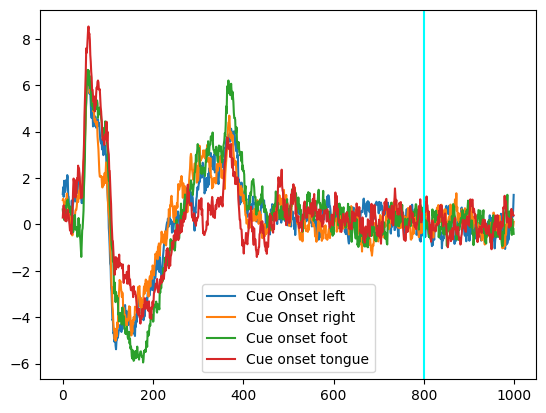

In [ ]:
## Visualizing the data


## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769
y_train_valid_subject_1 -= 769
y_test_subject_1 -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=800, label='line at t=800',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [ ]:
def train_data_prep(X,y, clip,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:clip]

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))

    # Subsampling
    for i in range(sub_sample):
        X_subsample = X[:, :, i::sub_sample] + \
                      (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
    return total_X,total_y


def val_test_data_prep(X, clip):
    total_X = None
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:clip]
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_aug = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    total_X = X_aug
    return total_X

In [ ]:
def data_loader(X_train_valid, y_train_valid, clip, model_choice="CNN"):
    num_data = X_train_valid.shape[0]
    data_ls = np.arange(num_data)
    np.random.shuffle(data_ls)

    val_ls = data_ls[0:num_data//5]
    val_label = y_train_valid[val_ls]
    val_data = X_train_valid[val_ls]
    val_data_aug = val_test_data_prep(val_data, clip)

    if model_choice == "CNN":
        val_data_aug = val_data_aug.reshape(val_data_aug.shape[0], val_data_aug.shape[1], val_data_aug.shape[2], 1)     # CNN; add extra dim for 2D conv
    elif model_choice == "EEGNet":
        val_data_aug = val_data_aug.reshape(val_data_aug.shape[0], 1, val_data_aug.shape[1], val_data_aug.shape[2])     # EEGNet; add extra dim for 2D conv

    train_ls = data_ls[num_data//5::]
    train_label = y_train_valid[train_ls]
    train_data = X_train_valid[train_ls]
    train_data_aug, train_label_aug = train_data_prep(train_data, train_label, clip, 2, 2, True)

    if model_choice == "CNN":
        train_data_aug = train_data_aug.reshape(train_data_aug.shape[0], train_data_aug.shape[1], train_data_aug.shape[2], 1)     # CNN; add extra dim for 2D conv
    elif model_choice == "EEGNet":
        train_data_aug = train_data_aug.reshape(train_data_aug.shape[0], 1, train_data_aug.shape[1], train_data_aug.shape[2])

    # print("My training data: ", train_data_aug.shape)
    # print("My training label: ", train_label_aug.shape)
    # print()
    # print("My val data: ", val_data_aug.shape)
    # print("My val label: ", val_label.shape)
    # print()

    return torch.from_numpy(train_data_aug), torch.from_numpy(train_label_aug), torch.from_numpy(val_data_aug), torch.from_numpy(val_label)


def batch_data(train_num, batch_size):
    data_ls = np.arange(train_num)
    np.random.shuffle(data_ls)  # shuffle augmented training data

    split_ls = np.repeat(batch_size, train_num//batch_size)

    if train_num%batch_size != 0:
        split_ls = np.hstack([split_ls, train_num%batch_size])

    split_ls = np.cumsum(split_ls)
    mini_batch_ls = np.split(data_ls, split_ls)
    del mini_batch_ls[-1]

    return mini_batch_ls

In [ ]:
###################################################################################
## Plotting Figures ###############################################################
###################################################################################
def make_figure(time, accuracies, name="fig"):
    x_axis = time
    plt.plot(x_axis, accuracies, color='r', label='test accuracy')
    plt.xlabel('Sequence Time')
    plt.ylabel('Test Accuracies')
    plt.title('Test Accuracies over Sequence Time')
    plt.legend()
    plt.savefig(name + '.png')
    plt.show()

In [ ]:
###################################################################################
## Training Function ##############################################################
###################################################################################
def train_model(data, optimizer, criterion, model, batch_size = 64, epochs = 30):
    # Getting the appropriate cuda device
    # Initialize for each model setup
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')     # Assuming that we are on a CUDA machine, this should print a CUDA device:

    # Getting our data for training and validation
    x_train = data['x_train'].to(device, dtype = torch.float)
    y_train = data['y_train'].to(device, dtype = torch.long)
    x_valid = data['x_valid'].to(device, dtype=torch.float)
    y_valid = data['y_valid'].to(device, dtype=torch.long)
    num_training_data = x_train.shape[0]
    num_val_data = x_valid.shape[0]
    num_iterations = len(batch_data(num_training_data, batch_size))

    # Placing our model parameters in the GPU
    print("Current Model: ", model)

    # Initializing variables for tracking our loss and accuracies
    running_loss = 0
    training_acc = []
    validation_acc = []

    np.random.seed(247)
    torch.manual_seed(147)
    # Training loop
    for epoch in tqdm(range(epochs)):
        batch_list = batch_data(num_training_data, batch_size)
        # Preparing the model for training
        model.train()

        print("Epoch: ", epoch + 1)
        running_loss = 0.0

        for iter_ in range(num_iterations):
            train_batch = x_train[batch_list[iter_]].to(device, dtype=torch.float)
            label_batch = y_train[batch_list[iter_]].to(device, dtype=torch.long)
            model.zero_grad()
            outputs = model(train_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (iter_+1) % (num_iterations//4) == 0:
                print('[{}, {}] loss: {:.3f}'.format(epoch + 1, iter_ + 1, running_loss / (num_iterations//4)))
                running_loss = 0.0

        # Validation


        with torch.no_grad():
            model.eval()      # set to testing mode for BN and Dropout
            val_out = model(x_valid)     # no Batch in testing mode

            train_predict = torch.argmax(outputs, dim = 1)
            train_acc = torch.mean(torch.eq(label_batch, train_predict).float(), dtype = torch.float)
            training_acc.append(train_acc.cpu().numpy())

            val_predict = torch.argmax(val_out, dim=1)
            val_acc  = torch.mean(torch.eq(y_valid, val_predict).float(), dtype = torch.float)
            validation_acc.append(val_acc.cpu().numpy())
            print('Validation Accuracy: {}'.format(val_acc, dtype = torch.float))

    print("Finish Training")
    return np.array(training_acc), np.array(validation_acc)

In [ ]:
###################################################################################
## Testing Function ##############################################################
###################################################################################
def test_model(model, clip, model_choice="LSTM", X_test=X_test, y_test=y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')     # Assuming that we are on a CUDA machine, this should print a CUDA device:

    # check test acc
    x_test = val_test_data_prep(X_test, clip)

    if type(x_test)!=torch.Tensor:
        x_test = torch.from_numpy(x_test).to(device, dtype=torch.float)

        if model_choice == "CNN" or model_choice == "CLSTM":
            x_test = x_test.unsqueeze(-1)
        elif model_choice == "EEGNet":
            x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])


    if type(y_test)!=torch.Tensor:
        y_test = torch.from_numpy(y_test).to(device, dtype=torch.long)

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        model.eval()     # set to testing mod for BN and Dropout
        test_out = model(x_test)
        test_predict = torch.argmax(test_out, dim=1)

    num_test = x_test.shape[0]
    test_acc  = torch.sum((test_predict == y_test)).item()/num_test
    print("Test accuracy for ", model_choice, "is: ", test_acc)
    return test_acc

# **MODEL DEFINITION** for EEGNet

In [ ]:
##################################################################################
## Classification with an EEG Net ################################################
##################################################################################
class ConstrainedConv2d(nn.Conv2d):
    def forward(self, input):
        return F.conv2d(input, self.weight.clamp(min=-1.0, max=1.0), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


class EEGNet(nn.Module):
    def __init__(self, linear_input):
        super(EEGNet, self).__init__()

        layers=[]
        """
        block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                    input_shape = (Chans, Samples, 1),
                                    use_bias = False)(input1)
        block1       = BatchNormalization()(block1)
        block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                    depth_multiplier = D,
                                    depthwise_constraint = max_norm(1.))(block1)
        block1       = BatchNormalization()(block1)
        block1       = Activation('elu')(block1)
        block1       = AveragePooling2D((1, 4))(block1)
        block1       = dropoutType(dropoutRate)(block1)
        """
        num_classes=4
        num_channel = 22
        num_sample = 400
        fs = 250
        dropoutRate = 0.25
        filter_len = fs//2
        F1 = 8
        D = 2
        F2 = 16
        norm_rate = 0.25

        layers = []
        # Block 1
        # Input shape: N*1*C*T
        layers.append(nn.Conv2d(in_channels=1, out_channels=F1, kernel_size=[1, filter_len], padding='same', bias=False))
        layers.append(nn.BatchNorm2d(num_features=F1))
        layers.append(ConstrainedConv2d(in_channels=F1, out_channels=D*F1, groups=F1, kernel_size=[num_channel, 1], padding='valid', bias=False))
        layers.append(nn.BatchNorm2d(num_features=D*F1))
        layers.append(nn.ELU())
        layers.append(nn.AvgPool2d([1,4]))
        layers.append(nn.Dropout(dropoutRate))

        #Block2
        layers.append(nn.Conv2d(in_channels=D*F1, out_channels=D*F1, groups=D*F1, kernel_size=[1, filter_len//2], padding="same"))
        layers.append(nn.Conv2d(in_channels=D*F1, out_channels=F2, kernel_size=1))
        layers.append(nn.BatchNorm2d(num_features=F2))
        layers.append(nn.ELU())
        layers.append(nn.AvgPool2d([1,8]))
        layers.append(nn.Dropout(dropoutRate))
        layers.append(nn.Flatten())
        # layers.append(nn.LSTM(input_size=192, hidden_size=10, num_layers=1, dropout=0.4))
        layers.append(nn.Linear(in_features=linear_input, out_features=num_classes))
        self.model = nn.ModuleList(layers)


    def forward(self, x):
        for layer in self.model:
            x = layer(x)
            if type(x) == tuple:
                x = x[0]
        return x

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
eegnet = EEGNet(192).to(device)
summary(eegnet, input_size=[64, 1, 22, 400])

Layer (type:depth-idx)                   Output Shape              Param #
EEGNet                                   [64, 4]                   --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [64, 8, 22, 400]          1,000
│    └─BatchNorm2d: 2-2                  [64, 8, 22, 400]          16
│    └─ConstrainedConv2d: 2-3            [64, 16, 1, 400]          352
│    └─BatchNorm2d: 2-4                  [64, 16, 1, 400]          32
│    └─ELU: 2-5                          [64, 16, 1, 400]          --
│    └─AvgPool2d: 2-6                    [64, 16, 1, 100]          --
│    └─Dropout: 2-7                      [64, 16, 1, 100]          --
│    └─Conv2d: 2-8                       [64, 16, 1, 100]          1,008
│    └─Conv2d: 2-9                       [64, 16, 1, 100]          272
│    └─BatchNorm2d: 2-10                 [64, 16, 1, 100]          32
│    └─ELU: 2-11                         [64, 16, 1, 100]          --
│    └─

# Training Our Models for different data times

In [ ]:
###################################################################################
## Training and Testing The EEGNet ################################################
###################################################################################
models = []
test_accuracies = []
final_layer = [16, 48, 64, 96, 112, 144, 160, 192, 224, 240]
clips = np.arange(100, 1100, 100)

for i, clip in enumerate(clips):
    np.random.seed(247) # Setting the seed
    x_train_EEG, y_train_EEG, x_valid_EEG, y_valid_EEG= data_loader(X_train_valid, y_train_valid, clip, model_choice="EEGNet")

    # Defining and readying our model for training
    eegnet = EEGNet(final_layer[i]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(eegnet.parameters(), lr=1e-3, eps=1e-07, weight_decay=0.001)
    num_epoch, batch_size = 50, 64
    data_eegnet = {
        "x_train": x_train_EEG,
        "y_train": y_train_EEG,
        "x_valid": x_valid_EEG,
        "y_valid": y_valid_EEG
    }
    training_acc_EEGNet, validation_acc_EEGNet = train_model(data_eegnet, optimizer, criterion, eegnet, batch_size, num_epoch)

    models.append(eegnet)
    start_time = time.time()
    test_acc = test_model(eegnet, clip, model_choice="EEGNet", X_test=X_test, y_test=y_test)
    print("Time To Run: ", time.time() - start_time, "seconds")
    test_accuracies.append(test_acc)

Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=16, out_features=4

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.391
[1, 52] loss: 1.346


  2%|▏         | 1/50 [00:00<00:17,  2.81it/s]

[1, 78] loss: 1.348
[1, 104] loss: 1.305
Validation Accuracy: 0.39479905366897583
Epoch:  2
[2, 26] loss: 1.286


  4%|▍         | 2/50 [00:00<00:16,  2.97it/s]

[2, 52] loss: 1.263
[2, 78] loss: 1.284
[2, 104] loss: 1.268
Validation Accuracy: 0.44680851697921753
Epoch:  3
[3, 26] loss: 1.244
[3, 52] loss: 1.228
[3, 78] loss: 1.215


  6%|▌         | 3/50 [00:01<00:15,  3.01it/s]

[3, 104] loss: 1.230
Validation Accuracy: 0.5035461187362671
Epoch:  4
[4, 26] loss: 1.199
[4, 52] loss: 1.214


  8%|▊         | 4/50 [00:01<00:15,  3.02it/s]

[4, 78] loss: 1.187
[4, 104] loss: 1.174
Validation Accuracy: 0.5011820197105408
Epoch:  5
[5, 26] loss: 1.182


 10%|█         | 5/50 [00:01<00:14,  3.05it/s]

[5, 52] loss: 1.174
[5, 78] loss: 1.136
[5, 104] loss: 1.168
Validation Accuracy: 0.5035461187362671
Epoch:  6
[6, 26] loss: 1.170
[6, 52] loss: 1.120
[6, 78] loss: 1.143


 12%|█▏        | 6/50 [00:01<00:14,  3.01it/s]

[6, 104] loss: 1.160
Validation Accuracy: 0.5200945734977722
Epoch:  7
[7, 26] loss: 1.124
[7, 52] loss: 1.132


 14%|█▍        | 7/50 [00:02<00:14,  3.05it/s]

[7, 78] loss: 1.098
[7, 104] loss: 1.146
Validation Accuracy: 0.5177304744720459
Epoch:  8
[8, 26] loss: 1.112


 16%|█▌        | 8/50 [00:02<00:13,  3.08it/s]

[8, 52] loss: 1.101
[8, 78] loss: 1.134
[8, 104] loss: 1.129
Validation Accuracy: 0.5153664350509644
Epoch:  9
[9, 26] loss: 1.109
[9, 52] loss: 1.110
[9, 78] loss: 1.125


 18%|█▊        | 9/50 [00:02<00:13,  3.05it/s]

[9, 104] loss: 1.103
Validation Accuracy: 0.5200945734977722
Epoch:  10
[10, 26] loss: 1.122
[10, 52] loss: 1.099


 20%|██        | 10/50 [00:03<00:12,  3.08it/s]

[10, 78] loss: 1.087
[10, 104] loss: 1.049
Validation Accuracy: 0.5177304744720459
Epoch:  11
[11, 26] loss: 1.097


 22%|██▏       | 11/50 [00:03<00:12,  3.11it/s]

[11, 52] loss: 1.093
[11, 78] loss: 1.087
[11, 104] loss: 1.086
Validation Accuracy: 0.5484633445739746
Epoch:  12
[12, 26] loss: 1.073
[12, 52] loss: 1.085
[12, 78] loss: 1.053


 24%|██▍       | 12/50 [00:03<00:12,  3.11it/s]

[12, 104] loss: 1.083
Validation Accuracy: 0.5295508503913879
Epoch:  13
[13, 26] loss: 1.077
[13, 52] loss: 1.053


 26%|██▌       | 13/50 [00:04<00:11,  3.12it/s]

[13, 78] loss: 1.065
[13, 104] loss: 1.060
Validation Accuracy: 0.5579196214675903
Epoch:  14
[14, 26] loss: 1.082


 28%|██▊       | 14/50 [00:04<00:11,  3.14it/s]

[14, 52] loss: 1.069
[14, 78] loss: 1.050
[14, 104] loss: 1.080
Validation Accuracy: 0.5342789888381958
Epoch:  15
[15, 26] loss: 1.056
[15, 52] loss: 1.031
[15, 78] loss: 1.080


 30%|███       | 15/50 [00:04<00:11,  3.13it/s]

[15, 104] loss: 1.040
Validation Accuracy: 0.5390070676803589
Epoch:  16
[16, 26] loss: 1.020
[16, 52] loss: 1.037


 32%|███▏      | 16/50 [00:05<00:10,  3.15it/s]

[16, 78] loss: 1.044
[16, 104] loss: 1.086
Validation Accuracy: 0.5484633445739746
Epoch:  17
[17, 26] loss: 1.022


 34%|███▍      | 17/50 [00:05<00:10,  3.12it/s]

[17, 52] loss: 1.022
[17, 78] loss: 1.021
[17, 104] loss: 1.030
Validation Accuracy: 0.5271867513656616
Epoch:  18
[18, 26] loss: 1.018
[18, 52] loss: 1.021
[18, 78] loss: 1.018


 36%|███▌      | 18/50 [00:05<00:10,  3.09it/s]

[18, 104] loss: 1.030
Validation Accuracy: 0.5224586129188538
Epoch:  19
[19, 26] loss: 1.037
[19, 52] loss: 1.029


 38%|███▊      | 19/50 [00:06<00:09,  3.11it/s]

[19, 78] loss: 1.012
[19, 104] loss: 1.017
Validation Accuracy: 0.5508274435997009
Epoch:  20
[20, 26] loss: 1.020


 40%|████      | 20/50 [00:06<00:09,  3.13it/s]

[20, 52] loss: 1.025
[20, 78] loss: 1.034
[20, 104] loss: 1.015
Validation Accuracy: 0.5508274435997009
Epoch:  21
[21, 26] loss: 1.013
[21, 52] loss: 0.994
[21, 78] loss: 1.021


 42%|████▏     | 21/50 [00:06<00:09,  3.15it/s]

[21, 104] loss: 0.998
Validation Accuracy: 0.5437352061271667
Epoch:  22
[22, 26] loss: 1.014
[22, 52] loss: 0.997


 44%|████▍     | 22/50 [00:07<00:08,  3.15it/s]

[22, 78] loss: 1.017
[22, 104] loss: 0.999
Validation Accuracy: 0.5248227119445801
Epoch:  23
[23, 26] loss: 1.000


 46%|████▌     | 23/50 [00:07<00:08,  3.12it/s]

[23, 52] loss: 1.008
[23, 78] loss: 0.980
[23, 104] loss: 1.018
Validation Accuracy: 0.5555555820465088
Epoch:  24
[24, 26] loss: 0.964
[24, 52] loss: 1.017
[24, 78] loss: 1.017


 48%|████▊     | 24/50 [00:07<00:08,  3.12it/s]

[24, 104] loss: 1.003
Validation Accuracy: 0.5437352061271667
Epoch:  25
[25, 26] loss: 0.974
[25, 52] loss: 0.998


 50%|█████     | 25/50 [00:08<00:07,  3.13it/s]

[25, 78] loss: 1.005
[25, 104] loss: 1.008
Validation Accuracy: 0.5579196214675903
Epoch:  26
[26, 26] loss: 0.999


 52%|█████▏    | 26/50 [00:08<00:07,  3.19it/s]

[26, 52] loss: 1.005
[26, 78] loss: 1.003
[26, 104] loss: 1.005
Validation Accuracy: 0.5579196214675903
Epoch:  27
[27, 26] loss: 0.980
[27, 52] loss: 0.985
[27, 78] loss: 1.004


 54%|█████▍    | 27/50 [00:08<00:07,  3.20it/s]

[27, 104] loss: 0.989
Validation Accuracy: 0.5295508503913879
Epoch:  28
[28, 26] loss: 0.993
[28, 52] loss: 1.003


 56%|█████▌    | 28/50 [00:09<00:06,  3.19it/s]

[28, 78] loss: 1.013
[28, 104] loss: 0.967
Validation Accuracy: 0.5697399377822876
Epoch:  29
[29, 26] loss: 0.998


 58%|█████▊    | 29/50 [00:09<00:06,  3.21it/s]

[29, 52] loss: 0.965
[29, 78] loss: 0.983
[29, 104] loss: 0.982
Validation Accuracy: 0.5791962146759033
Epoch:  30
[30, 26] loss: 0.985
[30, 52] loss: 0.992
[30, 78] loss: 0.961


 60%|██████    | 30/50 [00:09<00:06,  3.16it/s]

[30, 104] loss: 0.986
Validation Accuracy: 0.5626477599143982
Epoch:  31
[31, 26] loss: 0.969
[31, 52] loss: 0.969
[31, 78] loss: 0.984


 62%|██████▏   | 31/50 [00:10<00:06,  2.85it/s]

[31, 104] loss: 0.970
Validation Accuracy: 0.5650117993354797
Epoch:  32
[32, 26] loss: 0.966


 64%|██████▍   | 32/50 [00:10<00:06,  2.76it/s]

[32, 52] loss: 0.972
[32, 78] loss: 0.971
[32, 104] loss: 0.964
Validation Accuracy: 0.5555555820465088
Epoch:  33
[33, 26] loss: 0.981
[33, 52] loss: 1.004


 66%|██████▌   | 33/50 [00:10<00:06,  2.63it/s]

[33, 78] loss: 0.957
[33, 104] loss: 0.952
Validation Accuracy: 0.5390070676803589
Epoch:  34
[34, 26] loss: 0.969
[34, 52] loss: 0.960
[34, 78] loss: 0.944


 68%|██████▊   | 34/50 [00:11<00:06,  2.48it/s]

[34, 104] loss: 0.982
Validation Accuracy: 0.5531914830207825
Epoch:  35
[35, 26] loss: 0.959
[35, 52] loss: 0.974
[35, 78] loss: 0.978


 70%|███████   | 35/50 [00:11<00:06,  2.43it/s]

[35, 104] loss: 0.955
Validation Accuracy: 0.5437352061271667
Epoch:  36
[36, 26] loss: 0.940
[36, 52] loss: 0.949
[36, 78] loss: 0.956


 72%|███████▏  | 36/50 [00:12<00:05,  2.34it/s]

[36, 104] loss: 0.977
Validation Accuracy: 0.5342789888381958
Epoch:  37
[37, 26] loss: 0.947


 74%|███████▍  | 37/50 [00:12<00:05,  2.40it/s]

[37, 52] loss: 0.979
[37, 78] loss: 0.958
[37, 104] loss: 0.981
Validation Accuracy: 0.5342789888381958
Epoch:  38
[38, 26] loss: 0.952
[38, 52] loss: 0.968
[38, 78] loss: 0.971


 76%|███████▌  | 38/50 [00:12<00:04,  2.56it/s]

[38, 104] loss: 0.935
Validation Accuracy: 0.567375898361206
Epoch:  39
[39, 26] loss: 0.956
[39, 52] loss: 0.932


 78%|███████▊  | 39/50 [00:13<00:04,  2.69it/s]

[39, 78] loss: 0.938
[39, 104] loss: 0.946
Validation Accuracy: 0.5342789888381958
Epoch:  40
[40, 26] loss: 0.926


 80%|████████  | 40/50 [00:13<00:03,  2.79it/s]

[40, 52] loss: 0.970
[40, 78] loss: 0.964
[40, 104] loss: 0.944
Validation Accuracy: 0.5248227119445801
Epoch:  41
[41, 26] loss: 0.924
[41, 52] loss: 0.949
[41, 78] loss: 0.971


 82%|████████▏ | 41/50 [00:13<00:03,  2.89it/s]

[41, 104] loss: 0.956
Validation Accuracy: 0.5555555820465088
Epoch:  42
[42, 26] loss: 0.964
[42, 52] loss: 0.940


 84%|████████▍ | 42/50 [00:14<00:02,  2.93it/s]

[42, 78] loss: 0.947
[42, 104] loss: 0.965
Validation Accuracy: 0.5224586129188538
Epoch:  43
[43, 26] loss: 0.933


 86%|████████▌ | 43/50 [00:14<00:02,  3.03it/s]

[43, 52] loss: 0.936
[43, 78] loss: 0.951
[43, 104] loss: 0.954
Validation Accuracy: 0.5579196214675903
Epoch:  44
[44, 26] loss: 0.944
[44, 52] loss: 0.955
[44, 78] loss: 0.929


 88%|████████▊ | 44/50 [00:14<00:01,  3.08it/s]

[44, 104] loss: 0.933
Validation Accuracy: 0.5460993051528931
Epoch:  45
[45, 26] loss: 0.922
[45, 52] loss: 0.917


 90%|█████████ | 45/50 [00:15<00:01,  3.08it/s]

[45, 78] loss: 0.948
[45, 104] loss: 0.975
Validation Accuracy: 0.5319148898124695
Epoch:  46
[46, 26] loss: 0.926


 92%|█████████▏| 46/50 [00:15<00:01,  3.11it/s]

[46, 52] loss: 0.939
[46, 78] loss: 0.964
[46, 104] loss: 0.942
Validation Accuracy: 0.5390070676803589
Epoch:  47
[47, 26] loss: 0.926
[47, 52] loss: 0.942
[47, 78] loss: 0.934


 94%|█████████▍| 47/50 [00:15<00:00,  3.12it/s]

[47, 104] loss: 0.941
Validation Accuracy: 0.5508274435997009
Epoch:  48
[48, 26] loss: 0.933
[48, 52] loss: 0.906


 96%|█████████▌| 48/50 [00:16<00:00,  3.17it/s]

[48, 78] loss: 0.908
[48, 104] loss: 0.951
Validation Accuracy: 0.5555555820465088
Epoch:  49
[49, 26] loss: 0.920


 98%|█████████▊| 49/50 [00:16<00:00,  3.17it/s]

[49, 52] loss: 0.905
[49, 78] loss: 0.920
[49, 104] loss: 0.975
Validation Accuracy: 0.5721040368080139
Epoch:  50
[50, 26] loss: 0.937
[50, 52] loss: 0.914
[50, 78] loss: 0.970


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]

[50, 104] loss: 0.936
Validation Accuracy: 0.5744680762290955
Finish Training
Test accuracy for  EEGNet is:  0.5259593679458239
Time To Run:  0.032024383544921875 seconds


Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=48, out_features=4

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.370
[1, 52] loss: 1.330


  2%|▏         | 1/50 [00:00<00:16,  2.90it/s]

[1, 78] loss: 1.316
[1, 104] loss: 1.270
Validation Accuracy: 0.4444444477558136
Epoch:  2
[2, 26] loss: 1.237


  4%|▍         | 2/50 [00:00<00:16,  2.97it/s]

[2, 52] loss: 1.202
[2, 78] loss: 1.208
[2, 104] loss: 1.202
Validation Accuracy: 0.4869976341724396
Epoch:  3
[3, 26] loss: 1.166
[3, 52] loss: 1.153
[3, 78] loss: 1.163


  6%|▌         | 3/50 [00:01<00:15,  3.01it/s]

[3, 104] loss: 1.162
Validation Accuracy: 0.5011820197105408
Epoch:  4
[4, 26] loss: 1.140
[4, 52] loss: 1.133


  8%|▊         | 4/50 [00:01<00:15,  3.05it/s]

[4, 78] loss: 1.123
[4, 104] loss: 1.097
Validation Accuracy: 0.49881798028945923
Epoch:  5
[5, 26] loss: 1.109


 10%|█         | 5/50 [00:01<00:14,  3.05it/s]

[5, 52] loss: 1.101
[5, 78] loss: 1.094
[5, 104] loss: 1.092
Validation Accuracy: 0.5035461187362671
Epoch:  6
[6, 26] loss: 1.072
[6, 52] loss: 1.052
[6, 78] loss: 1.042


 12%|█▏        | 6/50 [00:01<00:14,  3.05it/s]

[6, 104] loss: 1.087
Validation Accuracy: 0.5224586129188538
Epoch:  7
[7, 26] loss: 1.031
[7, 52] loss: 1.055


 14%|█▍        | 7/50 [00:02<00:14,  3.06it/s]

[7, 78] loss: 1.030
[7, 104] loss: 1.054
Validation Accuracy: 0.5413711667060852
Epoch:  8
[8, 26] loss: 1.012


 16%|█▌        | 8/50 [00:02<00:13,  3.05it/s]

[8, 52] loss: 1.016
[8, 78] loss: 1.019
[8, 104] loss: 1.046
Validation Accuracy: 0.5508274435997009
Epoch:  9
[9, 26] loss: 1.003
[9, 52] loss: 0.996
[9, 78] loss: 1.017


 18%|█▊        | 9/50 [00:02<00:13,  3.07it/s]

[9, 104] loss: 0.975
Validation Accuracy: 0.5319148898124695
Epoch:  10
[10, 26] loss: 0.991
[10, 52] loss: 1.009


 20%|██        | 10/50 [00:03<00:12,  3.08it/s]

[10, 78] loss: 0.980
[10, 104] loss: 0.958
Validation Accuracy: 0.5555555820465088
Epoch:  11
[11, 26] loss: 0.995


 22%|██▏       | 11/50 [00:03<00:12,  3.04it/s]

[11, 52] loss: 0.948
[11, 78] loss: 0.974
[11, 104] loss: 0.973
Validation Accuracy: 0.5791962146759033
Epoch:  12
[12, 26] loss: 0.987
[12, 52] loss: 0.946
[12, 78] loss: 0.960


 24%|██▍       | 12/50 [00:03<00:12,  3.05it/s]

[12, 104] loss: 0.947
Validation Accuracy: 0.5413711667060852
Epoch:  13
[13, 26] loss: 0.972
[13, 52] loss: 0.940


 26%|██▌       | 13/50 [00:04<00:12,  3.04it/s]

[13, 78] loss: 0.937
[13, 104] loss: 0.945
Validation Accuracy: 0.5862883925437927
Epoch:  14
[14, 26] loss: 0.941


 28%|██▊       | 14/50 [00:04<00:11,  3.01it/s]

[14, 52] loss: 0.943
[14, 78] loss: 0.921
[14, 104] loss: 0.949
Validation Accuracy: 0.5815603137016296
Epoch:  15
[15, 26] loss: 0.929
[15, 52] loss: 0.950
[15, 78] loss: 0.939


 30%|███       | 15/50 [00:05<00:12,  2.86it/s]

[15, 104] loss: 0.897
Validation Accuracy: 0.5791962146759033
Epoch:  16
[16, 26] loss: 0.883
[16, 52] loss: 0.910
[16, 78] loss: 0.925
[16, 104] loss: 0.914


 32%|███▏      | 16/50 [00:05<00:12,  2.70it/s]

Validation Accuracy: 0.5862883925437927
Epoch:  17
[17, 26] loss: 0.924
[17, 52] loss: 0.892
[17, 78] loss: 0.909


 34%|███▍      | 17/50 [00:05<00:12,  2.54it/s]

[17, 104] loss: 0.907
Validation Accuracy: 0.5744680762290955
Epoch:  18
[18, 26] loss: 0.871
[18, 52] loss: 0.893
[18, 78] loss: 0.902
[18, 104] loss: 0.922


 36%|███▌      | 18/50 [00:06<00:12,  2.48it/s]

Validation Accuracy: 0.5839243531227112
Epoch:  19
[19, 26] loss: 0.877
[19, 52] loss: 0.877


 38%|███▊      | 19/50 [00:06<00:12,  2.49it/s]

[19, 78] loss: 0.885
[19, 104] loss: 0.895
Validation Accuracy: 0.6052009463310242
Epoch:  20
[20, 26] loss: 0.869
[20, 52] loss: 0.875
[20, 78] loss: 0.888


 40%|████      | 20/50 [00:07<00:12,  2.45it/s]

[20, 104] loss: 0.867
Validation Accuracy: 0.6075649857521057
Epoch:  21
[21, 26] loss: 0.864
[21, 52] loss: 0.864
[21, 78] loss: 0.887


 42%|████▏     | 21/50 [00:07<00:12,  2.36it/s]

[21, 104] loss: 0.863
Validation Accuracy: 0.5957446694374084
Epoch:  22
[22, 26] loss: 0.824


 44%|████▍     | 22/50 [00:07<00:11,  2.46it/s]

[22, 52] loss: 0.880
[22, 78] loss: 0.883
[22, 104] loss: 0.851
Validation Accuracy: 0.6170212626457214
Epoch:  23
[23, 26] loss: 0.842
[23, 52] loss: 0.869
[23, 78] loss: 0.809


 46%|████▌     | 23/50 [00:08<00:10,  2.63it/s]

[23, 104] loss: 0.896
Validation Accuracy: 0.6075649857521057
Epoch:  24
[24, 26] loss: 0.825
[24, 52] loss: 0.863


 48%|████▊     | 24/50 [00:08<00:09,  2.76it/s]

[24, 78] loss: 0.846
[24, 104] loss: 0.860
Validation Accuracy: 0.6241135001182556
Epoch:  25
[25, 26] loss: 0.848


 50%|█████     | 25/50 [00:08<00:08,  2.85it/s]

[25, 52] loss: 0.841
[25, 78] loss: 0.825
[25, 104] loss: 0.831
Validation Accuracy: 0.609929084777832
Epoch:  26
[26, 26] loss: 0.836
[26, 52] loss: 0.858
[26, 78] loss: 0.820


 52%|█████▏    | 26/50 [00:09<00:08,  2.91it/s]

[26, 104] loss: 0.858
Validation Accuracy: 0.6004728078842163
Epoch:  27
[27, 26] loss: 0.828
[27, 52] loss: 0.825


 54%|█████▍    | 27/50 [00:09<00:07,  2.96it/s]

[27, 78] loss: 0.822
[27, 104] loss: 0.810
Validation Accuracy: 0.6193853616714478
Epoch:  28
[28, 26] loss: 0.832


 56%|█████▌    | 28/50 [00:09<00:07,  2.91it/s]

[28, 52] loss: 0.822
[28, 78] loss: 0.829
[28, 104] loss: 0.804
Validation Accuracy: 0.6028369069099426
Epoch:  29
[29, 26] loss: 0.808
[29, 52] loss: 0.793
[29, 78] loss: 0.806


 58%|█████▊    | 29/50 [00:10<00:07,  2.94it/s]

[29, 104] loss: 0.813
Validation Accuracy: 0.6122931241989136
Epoch:  30
[30, 26] loss: 0.785
[30, 52] loss: 0.847


 60%|██████    | 30/50 [00:10<00:06,  2.99it/s]

[30, 78] loss: 0.812
[30, 104] loss: 0.800
Validation Accuracy: 0.6028369069099426
Epoch:  31
[31, 26] loss: 0.759


 62%|██████▏   | 31/50 [00:10<00:06,  3.00it/s]

[31, 52] loss: 0.804
[31, 78] loss: 0.805
[31, 104] loss: 0.790
Validation Accuracy: 0.609929084777832
Epoch:  32
[32, 26] loss: 0.793
[32, 52] loss: 0.768
[32, 78] loss: 0.820


 64%|██████▍   | 32/50 [00:11<00:05,  3.00it/s]

[32, 104] loss: 0.817
Validation Accuracy: 0.6217494010925293
Epoch:  33
[33, 26] loss: 0.798
[33, 52] loss: 0.795


 66%|██████▌   | 33/50 [00:11<00:05,  3.02it/s]

[33, 78] loss: 0.774
[33, 104] loss: 0.770
Validation Accuracy: 0.6193853616714478
Epoch:  34
[34, 26] loss: 0.816


 68%|██████▊   | 34/50 [00:11<00:05,  3.01it/s]

[34, 52] loss: 0.804
[34, 78] loss: 0.751
[34, 104] loss: 0.810
Validation Accuracy: 0.6359338164329529
Epoch:  35
[35, 26] loss: 0.793
[35, 52] loss: 0.767
[35, 78] loss: 0.773


 70%|███████   | 35/50 [00:12<00:04,  3.05it/s]

[35, 104] loss: 0.768
Validation Accuracy: 0.631205677986145
Epoch:  36
[36, 26] loss: 0.775
[36, 52] loss: 0.782


 72%|███████▏  | 36/50 [00:12<00:04,  3.05it/s]

[36, 78] loss: 0.767
[36, 104] loss: 0.787
Validation Accuracy: 0.6335697174072266
Epoch:  37
[37, 26] loss: 0.749


 74%|███████▍  | 37/50 [00:12<00:04,  3.03it/s]

[37, 52] loss: 0.774
[37, 78] loss: 0.756
[37, 104] loss: 0.795
Validation Accuracy: 0.6359338164329529
Epoch:  38
[38, 26] loss: 0.769
[38, 52] loss: 0.777
[38, 78] loss: 0.767


 76%|███████▌  | 38/50 [00:13<00:03,  3.04it/s]

[38, 104] loss: 0.758
Validation Accuracy: 0.631205677986145
Epoch:  39
[39, 26] loss: 0.770
[39, 52] loss: 0.749


 78%|███████▊  | 39/50 [00:13<00:03,  3.05it/s]

[39, 78] loss: 0.775
[39, 104] loss: 0.756
Validation Accuracy: 0.6146572232246399
Epoch:  40
[40, 26] loss: 0.740


 80%|████████  | 40/50 [00:13<00:03,  3.07it/s]

[40, 52] loss: 0.769
[40, 78] loss: 0.763
[40, 104] loss: 0.776
Validation Accuracy: 0.631205677986145
Epoch:  41
[41, 26] loss: 0.718
[41, 52] loss: 0.755
[41, 78] loss: 0.766


 82%|████████▏ | 41/50 [00:14<00:02,  3.06it/s]

[41, 104] loss: 0.800
Validation Accuracy: 0.6335697174072266
Epoch:  42
[42, 26] loss: 0.733
[42, 52] loss: 0.725


 84%|████████▍ | 42/50 [00:14<00:02,  3.05it/s]

[42, 78] loss: 0.752
[42, 104] loss: 0.765
Validation Accuracy: 0.6501182317733765
Epoch:  43
[43, 26] loss: 0.732


 86%|████████▌ | 43/50 [00:14<00:02,  3.04it/s]

[43, 52] loss: 0.744
[43, 78] loss: 0.728
[43, 104] loss: 0.778
Validation Accuracy: 0.6501182317733765
Epoch:  44
[44, 26] loss: 0.744
[44, 52] loss: 0.751
[44, 78] loss: 0.737


 88%|████████▊ | 44/50 [00:15<00:01,  3.03it/s]

[44, 104] loss: 0.732
Validation Accuracy: 0.6217494010925293
Epoch:  45
[45, 26] loss: 0.728
[45, 52] loss: 0.734


 90%|█████████ | 45/50 [00:15<00:01,  3.03it/s]

[45, 78] loss: 0.739
[45, 104] loss: 0.789
Validation Accuracy: 0.6572104096412659
Epoch:  46
[46, 26] loss: 0.731


 92%|█████████▏| 46/50 [00:15<00:01,  3.04it/s]

[46, 52] loss: 0.733
[46, 78] loss: 0.759
[46, 104] loss: 0.743
Validation Accuracy: 0.6430259943008423
Epoch:  47
[47, 26] loss: 0.711
[47, 52] loss: 0.740
[47, 78] loss: 0.764


 94%|█████████▍| 47/50 [00:16<00:00,  3.01it/s]

[47, 104] loss: 0.711
Validation Accuracy: 0.6382978558540344
Epoch:  48
[48, 26] loss: 0.704
[48, 52] loss: 0.704


 96%|█████████▌| 48/50 [00:16<00:00,  3.04it/s]

[48, 78] loss: 0.727
[48, 104] loss: 0.745
Validation Accuracy: 0.6359338164329529
Epoch:  49
[49, 26] loss: 0.736


 98%|█████████▊| 49/50 [00:16<00:00,  3.05it/s]

[49, 52] loss: 0.681
[49, 78] loss: 0.731
[49, 104] loss: 0.765
Validation Accuracy: 0.6217494010925293
Epoch:  50
[50, 26] loss: 0.713
[50, 52] loss: 0.705
[50, 78] loss: 0.709


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]

[50, 104] loss: 0.736
Validation Accuracy: 0.6477541327476501
Finish Training
Test accuracy for  EEGNet is:  0.6388261851015802
Time To Run:  0.05354452133178711 seconds


Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=64, out_features=4

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.373
[1, 52] loss: 1.337
[1, 78] loss: 1.309


  2%|▏         | 1/50 [00:00<00:23,  2.13it/s]

[1, 104] loss: 1.264
Validation Accuracy: 0.4302600622177124
Epoch:  2
[2, 26] loss: 1.225
[2, 52] loss: 1.191
[2, 78] loss: 1.174
[2, 104] loss: 1.169


  4%|▍         | 2/50 [00:00<00:21,  2.21it/s]

Validation Accuracy: 0.4822694957256317
Epoch:  3
[3, 26] loss: 1.145
[3, 52] loss: 1.110
[3, 78] loss: 1.118


  6%|▌         | 3/50 [00:01<00:21,  2.16it/s]

[3, 104] loss: 1.093
Validation Accuracy: 0.5200945734977722
Epoch:  4
[4, 26] loss: 1.080
[4, 52] loss: 1.074
[4, 78] loss: 1.078


  8%|▊         | 4/50 [00:01<00:21,  2.18it/s]

[4, 104] loss: 1.050
Validation Accuracy: 0.5342789888381958
Epoch:  5
[5, 26] loss: 1.024
[5, 52] loss: 1.045


 10%|█         | 5/50 [00:02<00:19,  2.33it/s]

[5, 78] loss: 1.001
[5, 104] loss: 1.029
Validation Accuracy: 0.5579196214675903
Epoch:  6
[6, 26] loss: 0.990
[6, 52] loss: 0.964
[6, 78] loss: 0.959


 12%|█▏        | 6/50 [00:02<00:18,  2.41it/s]

[6, 104] loss: 1.004
Validation Accuracy: 0.5721040368080139
Epoch:  7
[7, 26] loss: 0.965
[7, 52] loss: 0.976


 14%|█▍        | 7/50 [00:02<00:17,  2.49it/s]

[7, 78] loss: 0.951
[7, 104] loss: 0.948
Validation Accuracy: 0.5933806300163269
Epoch:  8
[8, 26] loss: 0.943


 16%|█▌        | 8/50 [00:03<00:16,  2.52it/s]

[8, 52] loss: 0.898
[8, 78] loss: 0.929
[8, 104] loss: 0.942
Validation Accuracy: 0.5933806300163269
Epoch:  9
[9, 26] loss: 0.888
[9, 52] loss: 0.903


 18%|█▊        | 9/50 [00:03<00:15,  2.57it/s]

[9, 78] loss: 0.909
[9, 104] loss: 0.873
Validation Accuracy: 0.6217494010925293
Epoch:  10
[10, 26] loss: 0.862


 20%|██        | 10/50 [00:04<00:15,  2.62it/s]

[10, 52] loss: 0.896
[10, 78] loss: 0.878
[10, 104] loss: 0.838
Validation Accuracy: 0.6572104096412659
Epoch:  11
[11, 26] loss: 0.898
[11, 52] loss: 0.840
[11, 78] loss: 0.848


 22%|██▏       | 11/50 [00:04<00:14,  2.62it/s]

[11, 104] loss: 0.828
Validation Accuracy: 0.652482271194458
Epoch:  12
[12, 26] loss: 0.832


 24%|██▍       | 12/50 [00:04<00:14,  2.61it/s]

[12, 52] loss: 0.834
[12, 78] loss: 0.847
[12, 104] loss: 0.805
Validation Accuracy: 0.6264775395393372
Epoch:  13
[13, 26] loss: 0.865
[13, 52] loss: 0.802
[13, 78] loss: 0.789


 26%|██▌       | 13/50 [00:05<00:14,  2.58it/s]

[13, 104] loss: 0.794
Validation Accuracy: 0.6619385480880737
Epoch:  14
[14, 26] loss: 0.835


 28%|██▊       | 14/50 [00:05<00:13,  2.59it/s]

[14, 52] loss: 0.800
[14, 78] loss: 0.762
[14, 104] loss: 0.812
Validation Accuracy: 0.6643025875091553
Epoch:  15
[15, 26] loss: 0.774
[15, 52] loss: 0.802
[15, 78] loss: 0.792


 30%|███       | 15/50 [00:06<00:13,  2.61it/s]

[15, 104] loss: 0.771
Validation Accuracy: 0.6572104096412659
Epoch:  16
[16, 26] loss: 0.714
[16, 52] loss: 0.785


 32%|███▏      | 16/50 [00:06<00:13,  2.61it/s]

[16, 78] loss: 0.789
[16, 104] loss: 0.797
Validation Accuracy: 0.6643025875091553
Epoch:  17
[17, 26] loss: 0.737


 34%|███▍      | 17/50 [00:06<00:12,  2.62it/s]

[17, 52] loss: 0.745
[17, 78] loss: 0.774
[17, 104] loss: 0.744
Validation Accuracy: 0.6548463106155396
Epoch:  18
[18, 26] loss: 0.728
[18, 52] loss: 0.742
[18, 78] loss: 0.766


 36%|███▌      | 18/50 [00:07<00:12,  2.63it/s]

[18, 104] loss: 0.797
Validation Accuracy: 0.6595744490623474
Epoch:  19
[19, 26] loss: 0.725


 38%|███▊      | 19/50 [00:07<00:11,  2.60it/s]

[19, 52] loss: 0.745
[19, 78] loss: 0.741
[19, 104] loss: 0.752
Validation Accuracy: 0.673758864402771
Epoch:  20
[20, 26] loss: 0.720
[20, 52] loss: 0.733
[20, 78] loss: 0.769


 40%|████      | 20/50 [00:07<00:11,  2.60it/s]

[20, 104] loss: 0.739
Validation Accuracy: 0.673758864402771
Epoch:  21
[21, 26] loss: 0.726
[21, 52] loss: 0.741


 42%|████▏     | 21/50 [00:08<00:11,  2.61it/s]

[21, 78] loss: 0.751
[21, 104] loss: 0.731
Validation Accuracy: 0.6713948249816895
Epoch:  22
[22, 26] loss: 0.737
[22, 52] loss: 0.731
[22, 78] loss: 0.736


 44%|████▍     | 22/50 [00:08<00:10,  2.59it/s]

[22, 104] loss: 0.705
Validation Accuracy: 0.6832151412963867
Epoch:  23
[23, 26] loss: 0.692
[23, 52] loss: 0.727


 46%|████▌     | 23/50 [00:09<00:10,  2.61it/s]

[23, 78] loss: 0.711
[23, 104] loss: 0.740
Validation Accuracy: 0.6690307259559631
Epoch:  24
[24, 26] loss: 0.708


 48%|████▊     | 24/50 [00:09<00:09,  2.61it/s]

[24, 52] loss: 0.693
[24, 78] loss: 0.734
[24, 104] loss: 0.749
Validation Accuracy: 0.6855791807174683
Epoch:  25
[25, 26] loss: 0.716
[25, 52] loss: 0.714
[25, 78] loss: 0.698


 50%|█████     | 25/50 [00:09<00:09,  2.62it/s]

[25, 104] loss: 0.702
Validation Accuracy: 0.7044917345046997
Epoch:  26
[26, 26] loss: 0.702
[26, 52] loss: 0.698


 52%|█████▏    | 26/50 [00:10<00:09,  2.62it/s]

[26, 78] loss: 0.698
[26, 104] loss: 0.701
Validation Accuracy: 0.6903073191642761
Epoch:  27
[27, 26] loss: 0.700


 54%|█████▍    | 27/50 [00:10<00:08,  2.61it/s]

[27, 52] loss: 0.704
[27, 78] loss: 0.693
[27, 104] loss: 0.672
Validation Accuracy: 0.6997635960578918
Epoch:  28
[28, 26] loss: 0.691
[28, 52] loss: 0.700
[28, 78] loss: 0.701


 56%|█████▌    | 28/50 [00:10<00:08,  2.62it/s]

[28, 104] loss: 0.681
Validation Accuracy: 0.6879432797431946
Epoch:  29
[29, 26] loss: 0.683
[29, 52] loss: 0.680


 58%|█████▊    | 29/50 [00:11<00:08,  2.60it/s]

[29, 78] loss: 0.693
[29, 104] loss: 0.685
Validation Accuracy: 0.6926714181900024
Epoch:  30
[30, 26] loss: 0.660
[30, 52] loss: 0.670
[30, 78] loss: 0.674


 60%|██████    | 30/50 [00:11<00:07,  2.55it/s]

[30, 104] loss: 0.672
Validation Accuracy: 0.6784870028495789
Epoch:  31
[31, 26] loss: 0.674
[31, 52] loss: 0.665
[31, 78] loss: 0.695


 62%|██████▏   | 31/50 [00:12<00:07,  2.42it/s]

[31, 104] loss: 0.670
Validation Accuracy: 0.6973995566368103
Epoch:  32
[32, 26] loss: 0.671
[32, 52] loss: 0.662
[32, 78] loss: 0.700


 64%|██████▍   | 32/50 [00:12<00:07,  2.37it/s]

[32, 104] loss: 0.687
Validation Accuracy: 0.6903073191642761
Epoch:  33
[33, 26] loss: 0.654
[33, 52] loss: 0.686
[33, 78] loss: 0.656


 66%|██████▌   | 33/50 [00:13<00:07,  2.32it/s]

[33, 104] loss: 0.650
Validation Accuracy: 0.7186761498451233
Epoch:  34
[34, 26] loss: 0.675
[34, 52] loss: 0.647
[34, 78] loss: 0.651


 68%|██████▊   | 34/50 [00:13<00:06,  2.32it/s]

[34, 104] loss: 0.673
Validation Accuracy: 0.7021276354789734
Epoch:  35
[35, 26] loss: 0.649
[35, 52] loss: 0.686
[35, 78] loss: 0.657


 70%|███████   | 35/50 [00:14<00:06,  2.31it/s]

[35, 104] loss: 0.661
Validation Accuracy: 0.6879432797431946
Epoch:  36
[36, 26] loss: 0.650
[36, 52] loss: 0.643
[36, 78] loss: 0.664


 72%|███████▏  | 36/50 [00:14<00:06,  2.26it/s]

[36, 104] loss: 0.664
Validation Accuracy: 0.6879432797431946
Epoch:  37
[37, 26] loss: 0.635


 74%|███████▍  | 37/50 [00:14<00:05,  2.31it/s]

[37, 52] loss: 0.674
[37, 78] loss: 0.632
[37, 104] loss: 0.659
Validation Accuracy: 0.7044917345046997
Epoch:  38
[38, 26] loss: 0.690
[38, 52] loss: 0.656
[38, 78] loss: 0.640


 76%|███████▌  | 38/50 [00:15<00:04,  2.41it/s]

[38, 104] loss: 0.650
Validation Accuracy: 0.7352246046066284
Epoch:  39
[39, 26] loss: 0.657
[39, 52] loss: 0.646


 78%|███████▊  | 39/50 [00:15<00:04,  2.46it/s]

[39, 78] loss: 0.659
[39, 104] loss: 0.636
Validation Accuracy: 0.6926714181900024
Epoch:  40
[40, 26] loss: 0.616
[40, 52] loss: 0.618
[40, 78] loss: 0.645


 80%|████████  | 40/50 [00:16<00:04,  2.48it/s]

[40, 104] loss: 0.622
Validation Accuracy: 0.7044917345046997
Epoch:  41
[41, 26] loss: 0.598
[41, 52] loss: 0.637


 82%|████████▏ | 41/50 [00:16<00:03,  2.51it/s]

[41, 78] loss: 0.653
[41, 104] loss: 0.653
Validation Accuracy: 0.7068557739257812
Epoch:  42
[42, 26] loss: 0.637
[42, 52] loss: 0.631
[42, 78] loss: 0.613
[42, 104] loss: 0.635


 84%|████████▍ | 42/50 [00:16<00:03,  2.52it/s]

Validation Accuracy: 0.7092198729515076
Epoch:  43
[43, 26] loss: 0.619
[43, 52] loss: 0.654


 86%|████████▌ | 43/50 [00:17<00:02,  2.55it/s]

[43, 78] loss: 0.623
[43, 104] loss: 0.625
Validation Accuracy: 0.7139480113983154
Epoch:  44
[44, 26] loss: 0.602


 88%|████████▊ | 44/50 [00:17<00:02,  2.57it/s]

[44, 52] loss: 0.615
[44, 78] loss: 0.635
[44, 104] loss: 0.628
Validation Accuracy: 0.7139480113983154
Epoch:  45
[45, 26] loss: 0.582
[45, 52] loss: 0.621
[45, 78] loss: 0.632


 90%|█████████ | 45/50 [00:17<00:01,  2.59it/s]

[45, 104] loss: 0.676
Validation Accuracy: 0.6926714181900024
Epoch:  46
[46, 26] loss: 0.636
[46, 52] loss: 0.625


 92%|█████████▏| 46/50 [00:18<00:01,  2.61it/s]

[46, 78] loss: 0.639
[46, 104] loss: 0.617
Validation Accuracy: 0.7257683277130127
Epoch:  47
[47, 26] loss: 0.598
[47, 52] loss: 0.615
[47, 78] loss: 0.632


 94%|█████████▍| 47/50 [00:18<00:01,  2.53it/s]

[47, 104] loss: 0.620
Validation Accuracy: 0.73758864402771
Epoch:  48
[48, 26] loss: 0.621
[48, 52] loss: 0.590
[48, 78] loss: 0.611


 96%|█████████▌| 48/50 [00:19<00:00,  2.45it/s]

[48, 104] loss: 0.609
Validation Accuracy: 0.716312050819397
Epoch:  49
[49, 26] loss: 0.603
[49, 52] loss: 0.565
[49, 78] loss: 0.589


 98%|█████████▊| 49/50 [00:19<00:00,  2.37it/s]

[49, 104] loss: 0.674
Validation Accuracy: 0.7139480113983154
Epoch:  50
[50, 26] loss: 0.629
[50, 52] loss: 0.591
[50, 78] loss: 0.604


100%|██████████| 50/50 [00:20<00:00,  2.48it/s]

[50, 104] loss: 0.591
Validation Accuracy: 0.716312050819397
Finish Training
Test accuracy for  EEGNet is:  0.7178329571106095
Time To Run:  0.10236310958862305 seconds


Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=96, out_features=4

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.371
[1, 52] loss: 1.325
[1, 78] loss: 1.282


  2%|▏         | 1/50 [00:00<00:26,  1.87it/s]

[1, 104] loss: 1.230
Validation Accuracy: 0.45390069484710693
Epoch:  2
[2, 26] loss: 1.193
[2, 52] loss: 1.165
[2, 78] loss: 1.136


  4%|▍         | 2/50 [00:00<00:22,  2.09it/s]

[2, 104] loss: 1.105
Validation Accuracy: 0.5650117993354797
Epoch:  3
[3, 26] loss: 1.060
[3, 52] loss: 1.029
[3, 78] loss: 1.047


  6%|▌         | 3/50 [00:01<00:21,  2.16it/s]

[3, 104] loss: 1.038
Validation Accuracy: 0.5697399377822876
Epoch:  4
[4, 26] loss: 1.008
[4, 52] loss: 0.991
[4, 78] loss: 0.995


  8%|▊         | 4/50 [00:01<00:20,  2.19it/s]

[4, 104] loss: 0.969
Validation Accuracy: 0.6075649857521057
Epoch:  5
[5, 26] loss: 0.979
[5, 52] loss: 0.964
[5, 78] loss: 0.936


 10%|█         | 5/50 [00:02<00:20,  2.22it/s]

[5, 104] loss: 0.985
Validation Accuracy: 0.5981087684631348
Epoch:  6
[6, 26] loss: 0.949
[6, 52] loss: 0.890
[6, 78] loss: 0.921


 12%|█▏        | 6/50 [00:02<00:20,  2.13it/s]

[6, 104] loss: 0.934
Validation Accuracy: 0.6193853616714478
Epoch:  7
[7, 26] loss: 0.869
[7, 52] loss: 0.894
[7, 78] loss: 0.908


 14%|█▍        | 7/50 [00:03<00:20,  2.11it/s]

[7, 104] loss: 0.892
Validation Accuracy: 0.6217494010925293
Epoch:  8
[8, 26] loss: 0.860
[8, 52] loss: 0.834
[8, 78] loss: 0.846


 16%|█▌        | 8/50 [00:03<00:20,  2.06it/s]

[8, 104] loss: 0.918
Validation Accuracy: 0.6288415789604187
Epoch:  9
[9, 26] loss: 0.813
[9, 52] loss: 0.836
[9, 78] loss: 0.860


 18%|█▊        | 9/50 [00:04<00:19,  2.05it/s]

[9, 104] loss: 0.837
Validation Accuracy: 0.6477541327476501
Epoch:  10
[10, 26] loss: 0.827
[10, 52] loss: 0.845
[10, 78] loss: 0.814


 20%|██        | 10/50 [00:04<00:19,  2.01it/s]

[10, 104] loss: 0.813
Validation Accuracy: 0.6619385480880737
Epoch:  11
[11, 26] loss: 0.830
[11, 52] loss: 0.786
[11, 78] loss: 0.787


 22%|██▏       | 11/50 [00:05<00:19,  2.00it/s]

[11, 104] loss: 0.780
Validation Accuracy: 0.6713948249816895
Epoch:  12
[12, 26] loss: 0.795
[12, 52] loss: 0.782
[12, 78] loss: 0.783


 24%|██▍       | 12/50 [00:05<00:18,  2.06it/s]

[12, 104] loss: 0.743
Validation Accuracy: 0.6713948249816895
Epoch:  13
[13, 26] loss: 0.798
[13, 52] loss: 0.769
[13, 78] loss: 0.733


 26%|██▌       | 13/50 [00:06<00:17,  2.12it/s]

[13, 104] loss: 0.743
Validation Accuracy: 0.6855791807174683
Epoch:  14
[14, 26] loss: 0.748
[14, 52] loss: 0.739
[14, 78] loss: 0.702


 28%|██▊       | 14/50 [00:06<00:16,  2.14it/s]

[14, 104] loss: 0.759
Validation Accuracy: 0.6832151412963867
Epoch:  15
[15, 26] loss: 0.721
[15, 52] loss: 0.775
[15, 78] loss: 0.753


 30%|███       | 15/50 [00:07<00:16,  2.17it/s]

[15, 104] loss: 0.716
Validation Accuracy: 0.695035457611084
Epoch:  16
[16, 26] loss: 0.729
[16, 52] loss: 0.715
[16, 78] loss: 0.746


 32%|███▏      | 16/50 [00:07<00:15,  2.19it/s]

[16, 104] loss: 0.723
Validation Accuracy: 0.6997635960578918
Epoch:  17
[17, 26] loss: 0.676
[17, 52] loss: 0.708
[17, 78] loss: 0.743


 34%|███▍      | 17/50 [00:08<00:14,  2.20it/s]

[17, 104] loss: 0.704
Validation Accuracy: 0.6713948249816895
Epoch:  18
[18, 26] loss: 0.676
[18, 52] loss: 0.720
[18, 78] loss: 0.743


 36%|███▌      | 18/50 [00:08<00:14,  2.22it/s]

[18, 104] loss: 0.727
Validation Accuracy: 0.6997635960578918
Epoch:  19
[19, 26] loss: 0.683
[19, 52] loss: 0.738
[19, 78] loss: 0.722


 38%|███▊      | 19/50 [00:08<00:13,  2.23it/s]

[19, 104] loss: 0.681
Validation Accuracy: 0.7021276354789734
Epoch:  20
[20, 26] loss: 0.657
[20, 52] loss: 0.706
[20, 78] loss: 0.724


 40%|████      | 20/50 [00:09<00:13,  2.23it/s]

[20, 104] loss: 0.677
Validation Accuracy: 0.7139480113983154
Epoch:  21
[21, 26] loss: 0.691
[21, 52] loss: 0.690
[21, 78] loss: 0.688


 42%|████▏     | 21/50 [00:09<00:12,  2.23it/s]

[21, 104] loss: 0.680
Validation Accuracy: 0.6903073191642761
Epoch:  22
[22, 26] loss: 0.667
[22, 52] loss: 0.700
[22, 78] loss: 0.670


 44%|████▍     | 22/50 [00:10<00:12,  2.24it/s]

[22, 104] loss: 0.662
Validation Accuracy: 0.6973995566368103
Epoch:  23
[23, 26] loss: 0.644
[23, 52] loss: 0.693
[23, 78] loss: 0.637


 46%|████▌     | 23/50 [00:10<00:12,  2.24it/s]

[23, 104] loss: 0.677
Validation Accuracy: 0.7092198729515076
Epoch:  24
[24, 26] loss: 0.635
[24, 52] loss: 0.634
[24, 78] loss: 0.674


 48%|████▊     | 24/50 [00:11<00:11,  2.24it/s]

[24, 104] loss: 0.677
Validation Accuracy: 0.7044917345046997
Epoch:  25
[25, 26] loss: 0.640
[25, 52] loss: 0.650
[25, 78] loss: 0.656


 50%|█████     | 25/50 [00:11<00:11,  2.23it/s]

[25, 104] loss: 0.647
Validation Accuracy: 0.7115839123725891
Epoch:  26
[26, 26] loss: 0.655
[26, 52] loss: 0.629
[26, 78] loss: 0.673


 52%|█████▏    | 26/50 [00:12<00:10,  2.23it/s]

[26, 104] loss: 0.635
Validation Accuracy: 0.7234042286872864
Epoch:  27
[27, 26] loss: 0.654
[27, 52] loss: 0.631
[27, 78] loss: 0.646


 54%|█████▍    | 27/50 [00:12<00:10,  2.23it/s]

[27, 104] loss: 0.638
Validation Accuracy: 0.7210401892662048
Epoch:  28
[28, 26] loss: 0.639
[28, 52] loss: 0.652
[28, 78] loss: 0.633


 56%|█████▌    | 28/50 [00:12<00:09,  2.23it/s]

[28, 104] loss: 0.632
Validation Accuracy: 0.7139480113983154
Epoch:  29
[29, 26] loss: 0.610
[29, 52] loss: 0.636
[29, 78] loss: 0.637


 58%|█████▊    | 29/50 [00:13<00:09,  2.20it/s]

[29, 104] loss: 0.627
Validation Accuracy: 0.7115839123725891
Epoch:  30
[30, 26] loss: 0.616
[30, 52] loss: 0.649
[30, 78] loss: 0.615


 60%|██████    | 30/50 [00:13<00:09,  2.21it/s]

[30, 104] loss: 0.633
Validation Accuracy: 0.7068557739257812
Epoch:  31
[31, 26] loss: 0.636
[31, 52] loss: 0.637
[31, 78] loss: 0.636


 62%|██████▏   | 31/50 [00:14<00:08,  2.21it/s]

[31, 104] loss: 0.612
Validation Accuracy: 0.7092198729515076
Epoch:  32
[32, 26] loss: 0.605
[32, 52] loss: 0.591
[32, 78] loss: 0.635


 64%|██████▍   | 32/50 [00:14<00:08,  2.23it/s]

[32, 104] loss: 0.635
Validation Accuracy: 0.7021276354789734
Epoch:  33
[33, 26] loss: 0.613
[33, 52] loss: 0.637
[33, 78] loss: 0.606


 66%|██████▌   | 33/50 [00:15<00:07,  2.22it/s]

[33, 104] loss: 0.614
Validation Accuracy: 0.7139480113983154
Epoch:  34
[34, 26] loss: 0.636
[34, 52] loss: 0.620
[34, 78] loss: 0.576


 68%|██████▊   | 34/50 [00:15<00:07,  2.13it/s]

[34, 104] loss: 0.626
Validation Accuracy: 0.716312050819397
Epoch:  35
[35, 26] loss: 0.581
[35, 52] loss: 0.619
[35, 78] loss: 0.620


 70%|███████   | 35/50 [00:16<00:07,  2.09it/s]

[35, 104] loss: 0.585
Validation Accuracy: 0.7092198729515076
Epoch:  36
[36, 26] loss: 0.603
[36, 52] loss: 0.590
[36, 78] loss: 0.609


 72%|███████▏  | 36/50 [00:16<00:06,  2.04it/s]

[36, 104] loss: 0.576
Validation Accuracy: 0.7115839123725891
Epoch:  37
[37, 26] loss: 0.586
[37, 52] loss: 0.621
[37, 78] loss: 0.604


 74%|███████▍  | 37/50 [00:17<00:06,  2.03it/s]

[37, 104] loss: 0.630
Validation Accuracy: 0.7210401892662048
Epoch:  38
[38, 26] loss: 0.602
[38, 52] loss: 0.613
[38, 78] loss: 0.582


 76%|███████▌  | 38/50 [00:17<00:06,  1.99it/s]

[38, 104] loss: 0.546
Validation Accuracy: 0.716312050819397
Epoch:  39
[39, 26] loss: 0.590
[39, 52] loss: 0.574
[39, 78] loss: 0.597


 78%|███████▊  | 39/50 [00:18<00:05,  1.99it/s]

[39, 104] loss: 0.583
Validation Accuracy: 0.7186761498451233
Epoch:  40
[40, 26] loss: 0.556
[40, 52] loss: 0.599
[40, 78] loss: 0.584


 80%|████████  | 40/50 [00:18<00:04,  2.06it/s]

[40, 104] loss: 0.590
Validation Accuracy: 0.7068557739257812
Epoch:  41
[41, 26] loss: 0.553
[41, 52] loss: 0.602
[41, 78] loss: 0.598


 82%|████████▏ | 41/50 [00:19<00:04,  2.11it/s]

[41, 104] loss: 0.588
Validation Accuracy: 0.7234042286872864
Epoch:  42
[42, 26] loss: 0.579
[42, 52] loss: 0.550
[42, 78] loss: 0.586


 84%|████████▍ | 42/50 [00:19<00:03,  2.14it/s]

[42, 104] loss: 0.609
Validation Accuracy: 0.7234042286872864
Epoch:  43
[43, 26] loss: 0.592
[43, 52] loss: 0.603
[43, 78] loss: 0.541


 86%|████████▌ | 43/50 [00:20<00:03,  2.17it/s]

[43, 104] loss: 0.587
Validation Accuracy: 0.7139480113983154
Epoch:  44
[44, 26] loss: 0.558
[44, 52] loss: 0.589
[44, 78] loss: 0.579


 88%|████████▊ | 44/50 [00:20<00:02,  2.18it/s]

[44, 104] loss: 0.578
Validation Accuracy: 0.7044917345046997
Epoch:  45
[45, 26] loss: 0.550
[45, 52] loss: 0.556
[45, 78] loss: 0.575


 90%|█████████ | 45/50 [00:20<00:02,  2.20it/s]

[45, 104] loss: 0.629
Validation Accuracy: 0.7304964661598206
Epoch:  46
[46, 26] loss: 0.559
[46, 52] loss: 0.567
[46, 78] loss: 0.581


 92%|█████████▏| 46/50 [00:21<00:01,  2.19it/s]

[46, 104] loss: 0.576
Validation Accuracy: 0.7068557739257812
Epoch:  47
[47, 26] loss: 0.563
[47, 52] loss: 0.562
[47, 78] loss: 0.567


 94%|█████████▍| 47/50 [00:21<00:01,  2.21it/s]

[47, 104] loss: 0.564
Validation Accuracy: 0.716312050819397
Epoch:  48
[48, 26] loss: 0.560
[48, 52] loss: 0.567
[48, 78] loss: 0.551


 96%|█████████▌| 48/50 [00:22<00:00,  2.21it/s]

[48, 104] loss: 0.587
Validation Accuracy: 0.7210401892662048
Epoch:  49
[49, 26] loss: 0.565
[49, 52] loss: 0.544
[49, 78] loss: 0.540


 98%|█████████▊| 49/50 [00:22<00:00,  2.23it/s]

[49, 104] loss: 0.627
Validation Accuracy: 0.7021276354789734
Epoch:  50
[50, 26] loss: 0.581
[50, 52] loss: 0.561
[50, 78] loss: 0.551


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]

[50, 104] loss: 0.549
Validation Accuracy: 0.7446808815002441
Finish Training
Test accuracy for  EEGNet is:  0.7200902934537246
Time To Run:  0.11554527282714844 seconds


Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=112, out_features=

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.350
[1, 52] loss: 1.278


  2%|▏         | 1/50 [00:00<00:31,  1.57it/s]

[1, 78] loss: 1.247
[1, 104] loss: 1.191
Validation Accuracy: 0.49172577261924744
Epoch:  2
[2, 26] loss: 1.157
[2, 52] loss: 1.120


  4%|▍         | 2/50 [00:01<00:27,  1.74it/s]

[2, 78] loss: 1.103
[2, 104] loss: 1.099
Validation Accuracy: 0.5531914830207825
Epoch:  3
[3, 26] loss: 1.067
[3, 52] loss: 1.033


  6%|▌         | 3/50 [00:01<00:26,  1.81it/s]

[3, 78] loss: 1.031
[3, 104] loss: 1.027
Validation Accuracy: 0.5650117993354797
Epoch:  4
[4, 26] loss: 0.988
[4, 52] loss: 1.000


  8%|▊         | 4/50 [00:02<00:25,  1.84it/s]

[4, 78] loss: 1.000
[4, 104] loss: 0.984
Validation Accuracy: 0.5862883925437927
Epoch:  5
[5, 26] loss: 0.964
[5, 52] loss: 0.962


 10%|█         | 5/50 [00:02<00:24,  1.84it/s]

[5, 78] loss: 0.946
[5, 104] loss: 0.974
Validation Accuracy: 0.6359338164329529
Epoch:  6
[6, 26] loss: 0.924
[6, 52] loss: 0.893


 12%|█▏        | 6/50 [00:03<00:24,  1.80it/s]

[6, 78] loss: 0.883
[6, 104] loss: 0.935
Validation Accuracy: 0.6288415789604187
Epoch:  7
[7, 26] loss: 0.895
[7, 52] loss: 0.905


 14%|█▍        | 7/50 [00:03<00:24,  1.78it/s]

[7, 78] loss: 0.890
[7, 104] loss: 0.873
Validation Accuracy: 0.6193853616714478
Epoch:  8
[8, 26] loss: 0.861
[8, 52] loss: 0.807


 16%|█▌        | 8/50 [00:04<00:23,  1.76it/s]

[8, 78] loss: 0.814
[8, 104] loss: 0.875
Validation Accuracy: 0.6430259943008423
Epoch:  9
[9, 26] loss: 0.808
[9, 52] loss: 0.815


 18%|█▊        | 9/50 [00:05<00:23,  1.75it/s]

[9, 78] loss: 0.834
[9, 104] loss: 0.806
Validation Accuracy: 0.6619385480880737
Epoch:  10
[10, 26] loss: 0.798
[10, 52] loss: 0.815


 20%|██        | 10/50 [00:05<00:23,  1.73it/s]

[10, 78] loss: 0.794
[10, 104] loss: 0.776
Validation Accuracy: 0.6572104096412659
Epoch:  11
[11, 26] loss: 0.804
[11, 52] loss: 0.765


 22%|██▏       | 11/50 [00:06<00:22,  1.77it/s]

[11, 78] loss: 0.777
[11, 104] loss: 0.763
Validation Accuracy: 0.6595744490623474
Epoch:  12
[12, 26] loss: 0.769
[12, 52] loss: 0.767


 24%|██▍       | 12/50 [00:06<00:21,  1.80it/s]

[12, 78] loss: 0.782
[12, 104] loss: 0.713
Validation Accuracy: 0.6595744490623474
Epoch:  13
[13, 26] loss: 0.773
[13, 52] loss: 0.759


 26%|██▌       | 13/50 [00:07<00:20,  1.82it/s]

[13, 78] loss: 0.710
[13, 104] loss: 0.712
Validation Accuracy: 0.6784870028495789
Epoch:  14
[14, 26] loss: 0.736
[14, 52] loss: 0.737


 28%|██▊       | 14/50 [00:07<00:19,  1.85it/s]

[14, 78] loss: 0.699
[14, 104] loss: 0.753
Validation Accuracy: 0.6548463106155396
Epoch:  15
[15, 26] loss: 0.709
[15, 52] loss: 0.724


 30%|███       | 15/50 [00:08<00:18,  1.85it/s]

[15, 78] loss: 0.717
[15, 104] loss: 0.688
Validation Accuracy: 0.6713948249816895
Epoch:  16
[16, 26] loss: 0.688
[16, 52] loss: 0.700


 32%|███▏      | 16/50 [00:08<00:18,  1.86it/s]

[16, 78] loss: 0.713
[16, 104] loss: 0.710
Validation Accuracy: 0.6855791807174683
Epoch:  17
[17, 26] loss: 0.688
[17, 52] loss: 0.683


 34%|███▍      | 17/50 [00:09<00:17,  1.87it/s]

[17, 78] loss: 0.718
[17, 104] loss: 0.714
Validation Accuracy: 0.673758864402771
Epoch:  18
[18, 26] loss: 0.675
[18, 52] loss: 0.689


 36%|███▌      | 18/50 [00:09<00:17,  1.87it/s]

[18, 78] loss: 0.713
[18, 104] loss: 0.692
Validation Accuracy: 0.7068557739257812
Epoch:  19
[19, 26] loss: 0.672
[19, 52] loss: 0.679


 38%|███▊      | 19/50 [00:10<00:16,  1.87it/s]

[19, 78] loss: 0.696
[19, 104] loss: 0.655
Validation Accuracy: 0.6761229038238525
Epoch:  20
[20, 26] loss: 0.648
[20, 52] loss: 0.679


 40%|████      | 20/50 [00:10<00:15,  1.88it/s]

[20, 78] loss: 0.691
[20, 104] loss: 0.654
Validation Accuracy: 0.7139480113983154
Epoch:  21
[21, 26] loss: 0.669
[21, 52] loss: 0.642


 42%|████▏     | 21/50 [00:11<00:15,  1.87it/s]

[21, 78] loss: 0.675
[21, 104] loss: 0.656
Validation Accuracy: 0.7139480113983154
Epoch:  22
[22, 26] loss: 0.645
[22, 52] loss: 0.686


 44%|████▍     | 22/50 [00:12<00:14,  1.88it/s]

[22, 78] loss: 0.668
[22, 104] loss: 0.637
Validation Accuracy: 0.7092198729515076
Epoch:  23
[23, 26] loss: 0.638
[23, 52] loss: 0.652


 46%|████▌     | 23/50 [00:12<00:14,  1.88it/s]

[23, 78] loss: 0.630
[23, 104] loss: 0.676
Validation Accuracy: 0.7139480113983154
Epoch:  24
[24, 26] loss: 0.663
[24, 52] loss: 0.647


 48%|████▊     | 24/50 [00:13<00:13,  1.88it/s]

[24, 78] loss: 0.642
[24, 104] loss: 0.683
Validation Accuracy: 0.6879432797431946
Epoch:  25
[25, 26] loss: 0.656
[25, 52] loss: 0.627


 50%|█████     | 25/50 [00:13<00:13,  1.89it/s]

[25, 78] loss: 0.637
[25, 104] loss: 0.644
Validation Accuracy: 0.6926714181900024
Epoch:  26
[26, 26] loss: 0.643
[26, 52] loss: 0.635


 52%|█████▏    | 26/50 [00:14<00:12,  1.89it/s]

[26, 78] loss: 0.651
[26, 104] loss: 0.668
Validation Accuracy: 0.7092198729515076
Epoch:  27
[27, 26] loss: 0.630
[27, 52] loss: 0.659


 54%|█████▍    | 27/50 [00:14<00:12,  1.89it/s]

[27, 78] loss: 0.613
[27, 104] loss: 0.621
Validation Accuracy: 0.7186761498451233
Epoch:  28
[28, 26] loss: 0.633
[28, 52] loss: 0.639


 56%|█████▌    | 28/50 [00:15<00:11,  1.89it/s]

[28, 78] loss: 0.591
[28, 104] loss: 0.631
Validation Accuracy: 0.6855791807174683
Epoch:  29
[29, 26] loss: 0.596
[29, 52] loss: 0.609


 58%|█████▊    | 29/50 [00:15<00:11,  1.88it/s]

[29, 78] loss: 0.646
[29, 104] loss: 0.629
Validation Accuracy: 0.716312050819397
Epoch:  30
[30, 26] loss: 0.619
[30, 52] loss: 0.597


 60%|██████    | 30/50 [00:16<00:10,  1.84it/s]

[30, 78] loss: 0.601
[30, 104] loss: 0.614
Validation Accuracy: 0.6903073191642761
Epoch:  31
[31, 26] loss: 0.624
[31, 52] loss: 0.618


 62%|██████▏   | 31/50 [00:16<00:10,  1.82it/s]

[31, 78] loss: 0.630
[31, 104] loss: 0.613
Validation Accuracy: 0.6997635960578918
Epoch:  32
[32, 26] loss: 0.606
[32, 52] loss: 0.572


 64%|██████▍   | 32/50 [00:17<00:09,  1.81it/s]

[32, 78] loss: 0.628
[32, 104] loss: 0.653
Validation Accuracy: 0.7234042286872864
Epoch:  33
[33, 26] loss: 0.595
[33, 52] loss: 0.628


 66%|██████▌   | 33/50 [00:18<00:09,  1.79it/s]

[33, 78] loss: 0.593
[33, 104] loss: 0.631
Validation Accuracy: 0.6997635960578918
Epoch:  34
[34, 26] loss: 0.572
[34, 52] loss: 0.619


 68%|██████▊   | 34/50 [00:18<00:09,  1.76it/s]

[34, 78] loss: 0.587
[34, 104] loss: 0.626
Validation Accuracy: 0.6973995566368103
Epoch:  35
[35, 26] loss: 0.615
[35, 52] loss: 0.585


 70%|███████   | 35/50 [00:19<00:08,  1.79it/s]

[35, 78] loss: 0.596
[35, 104] loss: 0.601
Validation Accuracy: 0.7068557739257812
Epoch:  36
[36, 26] loss: 0.601
[36, 52] loss: 0.623


 72%|███████▏  | 36/50 [00:19<00:07,  1.82it/s]

[36, 78] loss: 0.619
[36, 104] loss: 0.603
Validation Accuracy: 0.7044917345046997
Epoch:  37
[37, 26] loss: 0.578
[37, 52] loss: 0.576


 74%|███████▍  | 37/50 [00:20<00:07,  1.84it/s]

[37, 78] loss: 0.575
[37, 104] loss: 0.621
Validation Accuracy: 0.6973995566368103
Epoch:  38
[38, 26] loss: 0.595
[38, 52] loss: 0.624


 76%|███████▌  | 38/50 [00:20<00:06,  1.85it/s]

[38, 78] loss: 0.585
[38, 104] loss: 0.562
Validation Accuracy: 0.7234042286872864
Epoch:  39
[39, 26] loss: 0.581
[39, 52] loss: 0.576


 78%|███████▊  | 39/50 [00:21<00:05,  1.86it/s]

[39, 78] loss: 0.612
[39, 104] loss: 0.584
Validation Accuracy: 0.7068557739257812
Epoch:  40
[40, 26] loss: 0.539
[40, 52] loss: 0.597


 80%|████████  | 40/50 [00:21<00:05,  1.87it/s]

[40, 78] loss: 0.599
[40, 104] loss: 0.591
Validation Accuracy: 0.6926714181900024
Epoch:  41
[41, 26] loss: 0.541
[41, 52] loss: 0.602


 82%|████████▏ | 41/50 [00:22<00:04,  1.87it/s]

[41, 78] loss: 0.625
[41, 104] loss: 0.614
Validation Accuracy: 0.7115839123725891
Epoch:  42
[42, 26] loss: 0.590
[42, 52] loss: 0.563


 84%|████████▍ | 42/50 [00:22<00:04,  1.88it/s]

[42, 78] loss: 0.585
[42, 104] loss: 0.595
Validation Accuracy: 0.7328605055809021
Epoch:  43
[43, 26] loss: 0.558
[43, 52] loss: 0.594


 86%|████████▌ | 43/50 [00:23<00:03,  1.88it/s]

[43, 78] loss: 0.565
[43, 104] loss: 0.597
Validation Accuracy: 0.7068557739257812
Epoch:  44
[44, 26] loss: 0.555
[44, 52] loss: 0.597


 88%|████████▊ | 44/50 [00:23<00:03,  1.88it/s]

[44, 78] loss: 0.585
[44, 104] loss: 0.560
Validation Accuracy: 0.7139480113983154
Epoch:  45
[45, 26] loss: 0.537
[45, 52] loss: 0.569


 90%|█████████ | 45/50 [00:24<00:02,  1.88it/s]

[45, 78] loss: 0.583
[45, 104] loss: 0.595
Validation Accuracy: 0.7186761498451233
Epoch:  46
[46, 26] loss: 0.557
[46, 52] loss: 0.556


 92%|█████████▏| 46/50 [00:24<00:02,  1.88it/s]

[46, 78] loss: 0.587
[46, 104] loss: 0.566
Validation Accuracy: 0.7068557739257812
Epoch:  47
[47, 26] loss: 0.550
[47, 52] loss: 0.532


 94%|█████████▍| 47/50 [00:25<00:01,  1.89it/s]

[47, 78] loss: 0.574
[47, 104] loss: 0.563
Validation Accuracy: 0.73758864402771
Epoch:  48
[48, 26] loss: 0.554
[48, 52] loss: 0.548


 96%|█████████▌| 48/50 [00:26<00:01,  1.89it/s]

[48, 78] loss: 0.552
[48, 104] loss: 0.590
Validation Accuracy: 0.7115839123725891
Epoch:  49
[49, 26] loss: 0.538
[49, 52] loss: 0.518


 98%|█████████▊| 49/50 [00:26<00:00,  1.89it/s]

[49, 78] loss: 0.522
[49, 104] loss: 0.577
Validation Accuracy: 0.6855791807174683
Epoch:  50
[50, 26] loss: 0.564
[50, 52] loss: 0.587


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]

[50, 78] loss: 0.571
[50, 104] loss: 0.535
Validation Accuracy: 0.7304964661598206
Finish Training


Test accuracy for  EEGNet is:  0.7133182844243793
Time To Run:  0.12406373023986816 seconds
Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25, inplace=False

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.351
[1, 52] loss: 1.274


  2%|▏         | 1/50 [00:00<00:34,  1.41it/s]

[1, 78] loss: 1.228
[1, 104] loss: 1.159
Validation Accuracy: 0.508274257183075
Epoch:  2
[2, 26] loss: 1.133
[2, 52] loss: 1.091


  4%|▍         | 2/50 [00:01<00:32,  1.49it/s]

[2, 78] loss: 1.081
[2, 104] loss: 1.083
Validation Accuracy: 0.5413711667060852
Epoch:  3
[3, 26] loss: 1.054
[3, 52] loss: 1.024


  6%|▌         | 3/50 [00:01<00:30,  1.56it/s]

[3, 78] loss: 1.017
[3, 104] loss: 1.028
Validation Accuracy: 0.5437352061271667
Epoch:  4
[4, 26] loss: 0.976
[4, 52] loss: 0.948


  8%|▊         | 4/50 [00:02<00:28,  1.59it/s]

[4, 78] loss: 0.970
[4, 104] loss: 0.939
Validation Accuracy: 0.6004728078842163
Epoch:  5
[5, 26] loss: 0.920
[5, 52] loss: 0.900


 10%|█         | 5/50 [00:03<00:27,  1.61it/s]

[5, 78] loss: 0.870
[5, 104] loss: 0.883
Validation Accuracy: 0.6382978558540344
Epoch:  6
[6, 26] loss: 0.857
[6, 52] loss: 0.827


 12%|█▏        | 6/50 [00:03<00:27,  1.62it/s]

[6, 78] loss: 0.817
[6, 104] loss: 0.866
Validation Accuracy: 0.6217494010925293
Epoch:  7
[7, 26] loss: 0.803
[7, 52] loss: 0.833


 14%|█▍        | 7/50 [00:04<00:26,  1.63it/s]

[7, 78] loss: 0.799
[7, 104] loss: 0.795
Validation Accuracy: 0.673758864402771
Epoch:  8
[8, 26] loss: 0.780
[8, 52] loss: 0.762


 16%|█▌        | 8/50 [00:04<00:25,  1.63it/s]

[8, 78] loss: 0.763
[8, 104] loss: 0.803
Validation Accuracy: 0.6501182317733765
Epoch:  9
[9, 26] loss: 0.771
[9, 52] loss: 0.769


 18%|█▊        | 9/50 [00:05<00:25,  1.64it/s]

[9, 78] loss: 0.785
[9, 104] loss: 0.756
Validation Accuracy: 0.6643025875091553
Epoch:  10
[10, 26] loss: 0.751
[10, 52] loss: 0.759


 20%|██        | 10/50 [00:06<00:24,  1.64it/s]

[10, 78] loss: 0.764
[10, 104] loss: 0.766
Validation Accuracy: 0.6619385480880737
Epoch:  11
[11, 26] loss: 0.768
[11, 52] loss: 0.765


 22%|██▏       | 11/50 [00:06<00:23,  1.64it/s]

[11, 78] loss: 0.721
[11, 104] loss: 0.696
Validation Accuracy: 0.6973995566368103
Epoch:  12
[12, 26] loss: 0.709
[12, 52] loss: 0.732


 24%|██▍       | 12/50 [00:07<00:23,  1.64it/s]

[12, 78] loss: 0.754
[12, 104] loss: 0.680
Validation Accuracy: 0.6784870028495789
Epoch:  13
[13, 26] loss: 0.730
[13, 52] loss: 0.700


 26%|██▌       | 13/50 [00:08<00:22,  1.64it/s]

[13, 78] loss: 0.689
[13, 104] loss: 0.693
Validation Accuracy: 0.6832151412963867
Epoch:  14
[14, 26] loss: 0.697
[14, 52] loss: 0.696


 28%|██▊       | 14/50 [00:08<00:21,  1.64it/s]

[14, 78] loss: 0.679
[14, 104] loss: 0.717
Validation Accuracy: 0.6666666865348816
Epoch:  15
[15, 26] loss: 0.667
[15, 52] loss: 0.717


 30%|███       | 15/50 [00:09<00:21,  1.64it/s]

[15, 78] loss: 0.706
[15, 104] loss: 0.652
Validation Accuracy: 0.6666666865348816
Epoch:  16
[16, 26] loss: 0.676
[16, 52] loss: 0.686


 32%|███▏      | 16/50 [00:09<00:20,  1.64it/s]

[16, 78] loss: 0.681
[16, 104] loss: 0.684
Validation Accuracy: 0.6784870028495789
Epoch:  17
[17, 26] loss: 0.675
[17, 52] loss: 0.657


 34%|███▍      | 17/50 [00:10<00:20,  1.64it/s]

[17, 78] loss: 0.663
[17, 104] loss: 0.680
Validation Accuracy: 0.6832151412963867
Epoch:  18
[18, 26] loss: 0.636
[18, 52] loss: 0.668


 36%|███▌      | 18/50 [00:11<00:19,  1.64it/s]

[18, 78] loss: 0.699
[18, 104] loss: 0.675
Validation Accuracy: 0.7021276354789734
Epoch:  19
[19, 26] loss: 0.654
[19, 52] loss: 0.646


 38%|███▊      | 19/50 [00:11<00:19,  1.62it/s]

[19, 78] loss: 0.671
[19, 104] loss: 0.633
Validation Accuracy: 0.7021276354789734
Epoch:  20
[20, 26] loss: 0.633
[20, 52] loss: 0.656


 40%|████      | 20/50 [00:12<00:18,  1.61it/s]

[20, 78] loss: 0.676
[20, 104] loss: 0.658
Validation Accuracy: 0.7092198729515076
Epoch:  21
[21, 26] loss: 0.633
[21, 52] loss: 0.650


 42%|████▏     | 21/50 [00:12<00:18,  1.60it/s]

[21, 78] loss: 0.632
[21, 104] loss: 0.638
Validation Accuracy: 0.6997635960578918
Epoch:  22
[22, 26] loss: 0.646
[22, 52] loss: 0.645


 44%|████▍     | 22/50 [00:13<00:17,  1.59it/s]

[22, 78] loss: 0.630
[22, 104] loss: 0.620
Validation Accuracy: 0.6973995566368103
Epoch:  23
[23, 26] loss: 0.616
[23, 52] loss: 0.621


 46%|████▌     | 23/50 [00:14<00:17,  1.58it/s]

[23, 78] loss: 0.621
[23, 104] loss: 0.647
Validation Accuracy: 0.6832151412963867
Epoch:  24
[24, 26] loss: 0.590
[24, 52] loss: 0.644


 48%|████▊     | 24/50 [00:14<00:16,  1.59it/s]

[24, 78] loss: 0.608
[24, 104] loss: 0.629
Validation Accuracy: 0.6973995566368103
Epoch:  25
[25, 26] loss: 0.620
[25, 52] loss: 0.606


 50%|█████     | 25/50 [00:15<00:15,  1.61it/s]

[25, 78] loss: 0.623
[25, 104] loss: 0.598
Validation Accuracy: 0.7068557739257812
Epoch:  26
[26, 26] loss: 0.613
[26, 52] loss: 0.628


 52%|█████▏    | 26/50 [00:16<00:14,  1.61it/s]

[26, 78] loss: 0.594
[26, 104] loss: 0.623
Validation Accuracy: 0.6997635960578918
Epoch:  27
[27, 26] loss: 0.608
[27, 52] loss: 0.620


 54%|█████▍    | 27/50 [00:16<00:14,  1.62it/s]

[27, 78] loss: 0.595
[27, 104] loss: 0.588
Validation Accuracy: 0.716312050819397
Epoch:  28
[28, 26] loss: 0.604
[28, 52] loss: 0.624


 56%|█████▌    | 28/50 [00:17<00:13,  1.62it/s]

[28, 78] loss: 0.595
[28, 104] loss: 0.592
Validation Accuracy: 0.6784870028495789
Epoch:  29
[29, 26] loss: 0.573
[29, 52] loss: 0.569


 58%|█████▊    | 29/50 [00:17<00:12,  1.63it/s]

[29, 78] loss: 0.623
[29, 104] loss: 0.595
Validation Accuracy: 0.7115839123725891
Epoch:  30
[30, 26] loss: 0.583
[30, 52] loss: 0.589


 60%|██████    | 30/50 [00:18<00:12,  1.63it/s]

[30, 78] loss: 0.584
[30, 104] loss: 0.569
Validation Accuracy: 0.7139480113983154
Epoch:  31
[31, 26] loss: 0.586
[31, 52] loss: 0.598


 62%|██████▏   | 31/50 [00:19<00:11,  1.63it/s]

[31, 78] loss: 0.564
[31, 104] loss: 0.562
Validation Accuracy: 0.6997635960578918
Epoch:  32
[32, 26] loss: 0.597
[32, 52] loss: 0.607


 64%|██████▍   | 32/50 [00:19<00:11,  1.63it/s]

[32, 78] loss: 0.602
[32, 104] loss: 0.590
Validation Accuracy: 0.6997635960578918
Epoch:  33
[33, 26] loss: 0.542
[33, 52] loss: 0.576


 66%|██████▌   | 33/50 [00:20<00:10,  1.63it/s]

[33, 78] loss: 0.550
[33, 104] loss: 0.583
Validation Accuracy: 0.6832151412963867
Epoch:  34
[34, 26] loss: 0.562
[34, 52] loss: 0.543


 68%|██████▊   | 34/50 [00:21<00:09,  1.63it/s]

[34, 78] loss: 0.582
[34, 104] loss: 0.577
Validation Accuracy: 0.7044917345046997
Epoch:  35
[35, 26] loss: 0.560
[35, 52] loss: 0.566


 70%|███████   | 35/50 [00:21<00:09,  1.63it/s]

[35, 78] loss: 0.564
[35, 104] loss: 0.564
Validation Accuracy: 0.7115839123725891
Epoch:  36
[36, 26] loss: 0.527
[36, 52] loss: 0.568


 72%|███████▏  | 36/50 [00:22<00:08,  1.63it/s]

[36, 78] loss: 0.571
[36, 104] loss: 0.574
Validation Accuracy: 0.6903073191642761
Epoch:  37
[37, 26] loss: 0.542
[37, 52] loss: 0.545


 74%|███████▍  | 37/50 [00:22<00:07,  1.63it/s]

[37, 78] loss: 0.548
[37, 104] loss: 0.566
Validation Accuracy: 0.7068557739257812
Epoch:  38
[38, 26] loss: 0.563
[38, 52] loss: 0.565


 76%|███████▌  | 38/50 [00:23<00:07,  1.63it/s]

[38, 78] loss: 0.554
[38, 104] loss: 0.514
Validation Accuracy: 0.7092198729515076
Epoch:  39
[39, 26] loss: 0.546
[39, 52] loss: 0.537


 78%|███████▊  | 39/50 [00:24<00:06,  1.63it/s]

[39, 78] loss: 0.573
[39, 104] loss: 0.567
Validation Accuracy: 0.7044917345046997
Epoch:  40
[40, 26] loss: 0.514
[40, 52] loss: 0.538


 80%|████████  | 40/50 [00:24<00:06,  1.61it/s]

[40, 78] loss: 0.574
[40, 104] loss: 0.553
Validation Accuracy: 0.7068557739257812
Epoch:  41
[41, 26] loss: 0.502
[41, 52] loss: 0.573


 82%|████████▏ | 41/50 [00:25<00:05,  1.60it/s]

[41, 78] loss: 0.559
[41, 104] loss: 0.576
Validation Accuracy: 0.7257683277130127
Epoch:  42
[42, 26] loss: 0.573
[42, 52] loss: 0.499


 84%|████████▍ | 42/50 [00:26<00:05,  1.59it/s]

[42, 78] loss: 0.559
[42, 104] loss: 0.581
Validation Accuracy: 0.7234042286872864
Epoch:  43
[43, 26] loss: 0.526
[43, 52] loss: 0.552


 86%|████████▌ | 43/50 [00:26<00:04,  1.57it/s]

[43, 78] loss: 0.540
[43, 104] loss: 0.549
Validation Accuracy: 0.7021276354789734
Epoch:  44
[44, 26] loss: 0.508
[44, 52] loss: 0.559


 88%|████████▊ | 44/50 [00:27<00:03,  1.56it/s]

[44, 78] loss: 0.530
[44, 104] loss: 0.543
Validation Accuracy: 0.7139480113983154
Epoch:  45
[45, 26] loss: 0.518
[45, 52] loss: 0.549


 90%|█████████ | 45/50 [00:27<00:03,  1.58it/s]

[45, 78] loss: 0.490
[45, 104] loss: 0.566
Validation Accuracy: 0.716312050819397
Epoch:  46
[46, 26] loss: 0.551
[46, 52] loss: 0.510


 92%|█████████▏| 46/50 [00:28<00:02,  1.59it/s]

[46, 78] loss: 0.530
[46, 104] loss: 0.533
Validation Accuracy: 0.716312050819397
Epoch:  47
[47, 26] loss: 0.503
[47, 52] loss: 0.550


 94%|█████████▍| 47/50 [00:29<00:01,  1.60it/s]

[47, 78] loss: 0.525
[47, 104] loss: 0.519
Validation Accuracy: 0.7328605055809021
Epoch:  48
[48, 26] loss: 0.518
[48, 52] loss: 0.510


 96%|█████████▌| 48/50 [00:29<00:01,  1.60it/s]

[48, 78] loss: 0.531
[48, 104] loss: 0.545
Validation Accuracy: 0.7210401892662048
Epoch:  49
[49, 26] loss: 0.552
[49, 52] loss: 0.499


 98%|█████████▊| 49/50 [00:30<00:00,  1.61it/s]

[49, 78] loss: 0.516
[49, 104] loss: 0.570
Validation Accuracy: 0.7115839123725891
Epoch:  50
[50, 26] loss: 0.532
[50, 52] loss: 0.493


100%|██████████| 50/50 [00:31<00:00,  1.61it/s]

[50, 78] loss: 0.511
[50, 104] loss: 0.494
Validation Accuracy: 0.7234042286872864
Finish Training


Test accuracy for  EEGNet is:  0.7133182844243793
Time To Run:  0.15527677536010742 seconds
Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25, inplace=False

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.365
[1, 52] loss: 1.295


  2%|▏         | 1/50 [00:00<00:39,  1.24it/s]

[1, 78] loss: 1.248
[1, 104] loss: 1.177
Validation Accuracy: 0.4893617033958435
Epoch:  2
[2, 26] loss: 1.133
[2, 52] loss: 1.093


  4%|▍         | 2/50 [00:01<00:36,  1.32it/s]

[2, 78] loss: 1.070
[2, 104] loss: 1.075
Validation Accuracy: 0.5437352061271667
Epoch:  3
[3, 26] loss: 1.030
[3, 52] loss: 1.003
[3, 78] loss: 1.004


  6%|▌         | 3/50 [00:02<00:34,  1.35it/s]

[3, 104] loss: 1.024
Validation Accuracy: 0.567375898361206
Epoch:  4
[4, 26] loss: 0.967
[4, 52] loss: 0.961
[4, 78] loss: 0.966


  8%|▊         | 4/50 [00:02<00:33,  1.37it/s]

[4, 104] loss: 0.962
Validation Accuracy: 0.5650117993354797
Epoch:  5
[5, 26] loss: 0.934
[5, 52] loss: 0.917
[5, 78] loss: 0.896
[5, 104] loss: 0.913


 10%|█         | 5/50 [00:03<00:33,  1.36it/s]

Validation Accuracy: 0.5815603137016296
Epoch:  6
[6, 26] loss: 0.904
[6, 52] loss: 0.866
[6, 78] loss: 0.844


 12%|█▏        | 6/50 [00:04<00:32,  1.36it/s]

[6, 104] loss: 0.916
Validation Accuracy: 0.6193853616714478
Epoch:  7
[7, 26] loss: 0.828
[7, 52] loss: 0.853


 14%|█▍        | 7/50 [00:05<00:31,  1.36it/s]

[7, 78] loss: 0.816
[7, 104] loss: 0.816
Validation Accuracy: 0.6241135001182556
Epoch:  8
[8, 26] loss: 0.819
[8, 52] loss: 0.800
[8, 78] loss: 0.789


 16%|█▌        | 8/50 [00:05<00:30,  1.36it/s]

[8, 104] loss: 0.853
Validation Accuracy: 0.6359338164329529
Epoch:  9
[9, 26] loss: 0.743
[9, 52] loss: 0.776
[9, 78] loss: 0.799


 18%|█▊        | 9/50 [00:06<00:30,  1.37it/s]

[9, 104] loss: 0.772
Validation Accuracy: 0.6406619548797607
Epoch:  10
[10, 26] loss: 0.768
[10, 52] loss: 0.775
[10, 78] loss: 0.754


 20%|██        | 10/50 [00:07<00:29,  1.37it/s]

[10, 104] loss: 0.753
Validation Accuracy: 0.631205677986145
Epoch:  11
[11, 26] loss: 0.764
[11, 52] loss: 0.755
[11, 78] loss: 0.724


 22%|██▏       | 11/50 [00:08<00:28,  1.38it/s]

[11, 104] loss: 0.731
Validation Accuracy: 0.6501182317733765
Epoch:  12
[12, 26] loss: 0.757
[12, 52] loss: 0.706


 24%|██▍       | 12/50 [00:08<00:27,  1.38it/s]

[12, 78] loss: 0.757
[12, 104] loss: 0.714
Validation Accuracy: 0.6335697174072266
Epoch:  13
[13, 26] loss: 0.740
[13, 52] loss: 0.716
[13, 78] loss: 0.692


 26%|██▌       | 13/50 [00:09<00:26,  1.38it/s]

[13, 104] loss: 0.683
Validation Accuracy: 0.6453900933265686
Epoch:  14
[14, 26] loss: 0.689
[14, 52] loss: 0.692


 28%|██▊       | 14/50 [00:10<00:26,  1.38it/s]

[14, 78] loss: 0.680
[14, 104] loss: 0.668
Validation Accuracy: 0.6572104096412659
Epoch:  15
[15, 26] loss: 0.665
[15, 52] loss: 0.719
[15, 78] loss: 0.707


 30%|███       | 15/50 [00:10<00:25,  1.38it/s]

[15, 104] loss: 0.658
Validation Accuracy: 0.6713948249816895
Epoch:  16
[16, 26] loss: 0.670
[16, 52] loss: 0.680


 32%|███▏      | 16/50 [00:11<00:24,  1.39it/s]

[16, 78] loss: 0.706
[16, 104] loss: 0.689
Validation Accuracy: 0.6713948249816895
Epoch:  17
[17, 26] loss: 0.674
[17, 52] loss: 0.653


 34%|███▍      | 17/50 [00:12<00:23,  1.39it/s]

[17, 78] loss: 0.675
[17, 104] loss: 0.685
Validation Accuracy: 0.6973995566368103
Epoch:  18
[18, 26] loss: 0.622
[18, 52] loss: 0.660


 36%|███▌      | 18/50 [00:13<00:23,  1.39it/s]

[18, 78] loss: 0.682
[18, 104] loss: 0.644
Validation Accuracy: 0.6666666865348816
Epoch:  19
[19, 26] loss: 0.617
[19, 52] loss: 0.632
[19, 78] loss: 0.655


 38%|███▊      | 19/50 [00:13<00:22,  1.39it/s]

[19, 104] loss: 0.642
Validation Accuracy: 0.6879432797431946
Epoch:  20
[20, 26] loss: 0.619
[20, 52] loss: 0.640


 40%|████      | 20/50 [00:14<00:21,  1.39it/s]

[20, 78] loss: 0.637
[20, 104] loss: 0.613
Validation Accuracy: 0.6808510422706604
Epoch:  21
[21, 26] loss: 0.604
[21, 52] loss: 0.626


 42%|████▏     | 21/50 [00:15<00:20,  1.38it/s]

[21, 78] loss: 0.661
[21, 104] loss: 0.608
Validation Accuracy: 0.6926714181900024
Epoch:  22
[22, 26] loss: 0.600
[22, 52] loss: 0.633
[22, 78] loss: 0.636
[22, 104] loss: 0.612


 44%|████▍     | 22/50 [00:16<00:20,  1.38it/s]

Validation Accuracy: 0.6666666865348816
Epoch:  23
[23, 26] loss: 0.596
[23, 52] loss: 0.616
[23, 78] loss: 0.578


 46%|████▌     | 23/50 [00:16<00:19,  1.37it/s]

[23, 104] loss: 0.628
Validation Accuracy: 0.673758864402771
Epoch:  24
[24, 26] loss: 0.589
[24, 52] loss: 0.602


 48%|████▊     | 24/50 [00:17<00:18,  1.37it/s]

[24, 78] loss: 0.589
[24, 104] loss: 0.618
Validation Accuracy: 0.6855791807174683
Epoch:  25
[25, 26] loss: 0.583
[25, 52] loss: 0.607
[25, 78] loss: 0.592


 50%|█████     | 25/50 [00:18<00:18,  1.36it/s]

[25, 104] loss: 0.600
Validation Accuracy: 0.6808510422706604
Epoch:  26
[26, 26] loss: 0.593
[26, 52] loss: 0.584


 52%|█████▏    | 26/50 [00:18<00:17,  1.36it/s]

[26, 78] loss: 0.604
[26, 104] loss: 0.586
Validation Accuracy: 0.6761229038238525
Epoch:  27
[27, 26] loss: 0.602
[27, 52] loss: 0.573


 54%|█████▍    | 27/50 [00:19<00:16,  1.36it/s]

[27, 78] loss: 0.580
[27, 104] loss: 0.566
Validation Accuracy: 0.7068557739257812
Epoch:  28
[28, 26] loss: 0.567
[28, 52] loss: 0.605


 56%|█████▌    | 28/50 [00:20<00:16,  1.37it/s]

[28, 78] loss: 0.574
[28, 104] loss: 0.581
Validation Accuracy: 0.6973995566368103
Epoch:  29
[29, 26] loss: 0.592
[29, 52] loss: 0.552


 58%|█████▊    | 29/50 [00:21<00:15,  1.37it/s]

[29, 78] loss: 0.587
[29, 104] loss: 0.573
Validation Accuracy: 0.6643025875091553
Epoch:  30
[30, 26] loss: 0.544
[30, 52] loss: 0.551
[30, 78] loss: 0.562


 60%|██████    | 30/50 [00:21<00:14,  1.37it/s]

[30, 104] loss: 0.550
Validation Accuracy: 0.6855791807174683
Epoch:  31
[31, 26] loss: 0.551
[31, 52] loss: 0.564


 62%|██████▏   | 31/50 [00:22<00:13,  1.37it/s]

[31, 78] loss: 0.562
[31, 104] loss: 0.543
Validation Accuracy: 0.6903073191642761
Epoch:  32
[32, 26] loss: 0.563
[32, 52] loss: 0.543


 64%|██████▍   | 32/50 [00:23<00:13,  1.37it/s]

[32, 78] loss: 0.566
[32, 104] loss: 0.550
Validation Accuracy: 0.7186761498451233
Epoch:  33
[33, 26] loss: 0.546
[33, 52] loss: 0.568


 66%|██████▌   | 33/50 [00:24<00:12,  1.38it/s]

[33, 78] loss: 0.523
[33, 104] loss: 0.566
Validation Accuracy: 0.6619385480880737
Epoch:  34
[34, 26] loss: 0.545
[34, 52] loss: 0.538


 68%|██████▊   | 34/50 [00:24<00:11,  1.38it/s]

[34, 78] loss: 0.516
[34, 104] loss: 0.570
Validation Accuracy: 0.7139480113983154
Epoch:  35
[35, 26] loss: 0.535
[35, 52] loss: 0.523


 70%|███████   | 35/50 [00:25<00:10,  1.38it/s]

[35, 78] loss: 0.539
[35, 104] loss: 0.530
Validation Accuracy: 0.6643025875091553
Epoch:  36
[36, 26] loss: 0.516
[36, 52] loss: 0.544


 72%|███████▏  | 36/50 [00:26<00:10,  1.38it/s]

[36, 78] loss: 0.555
[36, 104] loss: 0.551
Validation Accuracy: 0.6997635960578918
Epoch:  37
[37, 26] loss: 0.523
[37, 52] loss: 0.530
[37, 78] loss: 0.518


 74%|███████▍  | 37/50 [00:26<00:09,  1.38it/s]

[37, 104] loss: 0.549
Validation Accuracy: 0.6973995566368103
Epoch:  38
[38, 26] loss: 0.556
[38, 52] loss: 0.545


 76%|███████▌  | 38/50 [00:27<00:08,  1.38it/s]

[38, 78] loss: 0.535
[38, 104] loss: 0.518
Validation Accuracy: 0.7021276354789734
Epoch:  39
[39, 26] loss: 0.523
[39, 52] loss: 0.523


 78%|███████▊  | 39/50 [00:28<00:07,  1.38it/s]

[39, 78] loss: 0.559
[39, 104] loss: 0.538
Validation Accuracy: 0.6973995566368103
Epoch:  40
[40, 26] loss: 0.496
[40, 52] loss: 0.522
[40, 78] loss: 0.558
[40, 104] loss: 0.512


 80%|████████  | 40/50 [00:29<00:07,  1.38it/s]

Validation Accuracy: 0.6855791807174683
Epoch:  41
[41, 26] loss: 0.485
[41, 52] loss: 0.511
[41, 78] loss: 0.533


 82%|████████▏ | 41/50 [00:29<00:06,  1.37it/s]

[41, 104] loss: 0.546
Validation Accuracy: 0.7044917345046997
Epoch:  42
[42, 26] loss: 0.489
[42, 52] loss: 0.540
[42, 78] loss: 0.530
[42, 104] loss: 0.534


 84%|████████▍ | 42/50 [00:30<00:05,  1.37it/s]

Validation Accuracy: 0.695035457611084
Epoch:  43
[43, 26] loss: 0.540
[43, 52] loss: 0.514
[43, 78] loss: 0.502


 86%|████████▌ | 43/50 [00:31<00:05,  1.36it/s]

[43, 104] loss: 0.507
Validation Accuracy: 0.673758864402771
Epoch:  44
[44, 26] loss: 0.503
[44, 52] loss: 0.530


 88%|████████▊ | 44/50 [00:32<00:04,  1.36it/s]

[44, 78] loss: 0.527
[44, 104] loss: 0.492
Validation Accuracy: 0.6832151412963867
Epoch:  45
[45, 26] loss: 0.520
[45, 52] loss: 0.509


 90%|█████████ | 45/50 [00:32<00:03,  1.37it/s]

[45, 78] loss: 0.505
[45, 104] loss: 0.528
Validation Accuracy: 0.695035457611084
Epoch:  46
[46, 26] loss: 0.521
[46, 52] loss: 0.517


 92%|█████████▏| 46/50 [00:33<00:02,  1.38it/s]

[46, 78] loss: 0.507
[46, 104] loss: 0.514
Validation Accuracy: 0.6832151412963867
Epoch:  47
[47, 26] loss: 0.495
[47, 52] loss: 0.504
[47, 78] loss: 0.517


 94%|█████████▍| 47/50 [00:34<00:02,  1.38it/s]

[47, 104] loss: 0.487
Validation Accuracy: 0.6808510422706604
Epoch:  48
[48, 26] loss: 0.476
[48, 52] loss: 0.497
[48, 78] loss: 0.492


 96%|█████████▌| 48/50 [00:34<00:01,  1.38it/s]

[48, 104] loss: 0.534
Validation Accuracy: 0.695035457611084
Epoch:  49
[49, 26] loss: 0.487
[49, 52] loss: 0.503


 98%|█████████▊| 49/50 [00:35<00:00,  1.38it/s]

[49, 78] loss: 0.500
[49, 104] loss: 0.526
Validation Accuracy: 0.6879432797431946
Epoch:  50
[50, 26] loss: 0.503
[50, 52] loss: 0.510


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]

[50, 78] loss: 0.493
[50, 104] loss: 0.484
Validation Accuracy: 0.7021276354789734


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


Finish Training
Test accuracy for  EEGNet is:  0.7133182844243793
Time To Run:  0.1735837459564209 seconds
Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.375
[1, 52] loss: 1.304
[1, 78] loss: 1.258
[1, 104] loss: 1.177


  2%|▏         | 1/50 [00:00<00:43,  1.13it/s]

Validation Accuracy: 0.5059101581573486
Epoch:  2
[2, 26] loss: 1.118
[2, 52] loss: 1.088
[2, 78] loss: 1.079


  4%|▍         | 2/50 [00:01<00:39,  1.20it/s]

[2, 104] loss: 1.032
Validation Accuracy: 0.5697399377822876
Epoch:  3
[3, 26] loss: 1.025
[3, 52] loss: 0.977
[3, 78] loss: 0.997
[3, 104] loss: 1.011


  6%|▌         | 3/50 [00:02<00:38,  1.22it/s]

Validation Accuracy: 0.5697399377822876
Epoch:  4
[4, 26] loss: 0.946
[4, 52] loss: 0.944
[4, 78] loss: 0.951


  8%|▊         | 4/50 [00:03<00:37,  1.23it/s]

[4, 104] loss: 0.932
Validation Accuracy: 0.5910165309906006
Epoch:  5
[5, 26] loss: 0.937
[5, 52] loss: 0.916
[5, 78] loss: 0.865
[5, 104] loss: 0.903


 10%|█         | 5/50 [00:04<00:36,  1.23it/s]

Validation Accuracy: 0.6193853616714478
Epoch:  6
[6, 26] loss: 0.858
[6, 52] loss: 0.822
[6, 78] loss: 0.834
[6, 104] loss: 0.887


 12%|█▏        | 6/50 [00:04<00:35,  1.23it/s]

Validation Accuracy: 0.6028369069099426
Epoch:  7
[7, 26] loss: 0.817
[7, 52] loss: 0.816
[7, 78] loss: 0.783


 14%|█▍        | 7/50 [00:05<00:34,  1.24it/s]

[7, 104] loss: 0.805
Validation Accuracy: 0.6359338164329529
Epoch:  8
[8, 26] loss: 0.789
[8, 52] loss: 0.780
[8, 78] loss: 0.768
[8, 104] loss: 0.803


 16%|█▌        | 8/50 [00:06<00:33,  1.25it/s]

Validation Accuracy: 0.6501182317733765
Epoch:  9
[9, 26] loss: 0.756
[9, 52] loss: 0.793
[9, 78] loss: 0.773


 18%|█▊        | 9/50 [00:07<00:32,  1.25it/s]

[9, 104] loss: 0.779
Validation Accuracy: 0.6453900933265686
Epoch:  10
[10, 26] loss: 0.750
[10, 52] loss: 0.757
[10, 78] loss: 0.753
[10, 104] loss: 0.745


 20%|██        | 10/50 [00:08<00:31,  1.26it/s]

Validation Accuracy: 0.6430259943008423
Epoch:  11
[11, 26] loss: 0.764
[11, 52] loss: 0.746
[11, 78] loss: 0.717


 22%|██▏       | 11/50 [00:08<00:31,  1.26it/s]

[11, 104] loss: 0.694
Validation Accuracy: 0.6619385480880737
Epoch:  12
[12, 26] loss: 0.702
[12, 52] loss: 0.682
[12, 78] loss: 0.743
[12, 104] loss: 0.705


 24%|██▍       | 12/50 [00:09<00:30,  1.26it/s]

Validation Accuracy: 0.6832151412963867
Epoch:  13
[13, 26] loss: 0.707
[13, 52] loss: 0.731
[13, 78] loss: 0.671


 26%|██▌       | 13/50 [00:10<00:29,  1.26it/s]

[13, 104] loss: 0.679
Validation Accuracy: 0.6572104096412659
Epoch:  14
[14, 26] loss: 0.690
[14, 52] loss: 0.689
[14, 78] loss: 0.661
[14, 104] loss: 0.672


 28%|██▊       | 14/50 [00:11<00:28,  1.26it/s]

Validation Accuracy: 0.6595744490623474
Epoch:  15
[15, 26] loss: 0.666
[15, 52] loss: 0.700
[15, 78] loss: 0.672


 30%|███       | 15/50 [00:12<00:27,  1.26it/s]

[15, 104] loss: 0.645
Validation Accuracy: 0.673758864402771
Epoch:  16
[16, 26] loss: 0.629
[16, 52] loss: 0.686
[16, 78] loss: 0.695
[16, 104] loss: 0.663


 32%|███▏      | 16/50 [00:12<00:26,  1.26it/s]

Validation Accuracy: 0.6808510422706604
Epoch:  17
[17, 26] loss: 0.644
[17, 52] loss: 0.636
[17, 78] loss: 0.668


 34%|███▍      | 17/50 [00:13<00:26,  1.26it/s]

[17, 104] loss: 0.644
Validation Accuracy: 0.6832151412963867
Epoch:  18
[18, 26] loss: 0.623
[18, 52] loss: 0.643
[18, 78] loss: 0.646
[18, 104] loss: 0.648


 36%|███▌      | 18/50 [00:14<00:25,  1.26it/s]

Validation Accuracy: 0.6903073191642761
Epoch:  19
[19, 26] loss: 0.629
[19, 52] loss: 0.621
[19, 78] loss: 0.647


 38%|███▊      | 19/50 [00:15<00:24,  1.25it/s]

[19, 104] loss: 0.599
Validation Accuracy: 0.7044917345046997
Epoch:  20
[20, 26] loss: 0.610
[20, 52] loss: 0.636
[20, 78] loss: 0.665
[20, 104] loss: 0.607


 40%|████      | 20/50 [00:16<00:24,  1.24it/s]

Validation Accuracy: 0.7044917345046997
Epoch:  21
[21, 26] loss: 0.620
[21, 52] loss: 0.616
[21, 78] loss: 0.639
[21, 104] loss: 0.600


 42%|████▏     | 21/50 [00:16<00:23,  1.23it/s]

Validation Accuracy: 0.6879432797431946
Epoch:  22
[22, 26] loss: 0.647
[22, 52] loss: 0.613
[22, 78] loss: 0.580
[22, 104] loss: 0.586


 44%|████▍     | 22/50 [00:17<00:22,  1.23it/s]

Validation Accuracy: 0.6973995566368103
Epoch:  23
[23, 26] loss: 0.583
[23, 52] loss: 0.610
[23, 78] loss: 0.579


 46%|████▌     | 23/50 [00:18<00:21,  1.23it/s]

[23, 104] loss: 0.626
Validation Accuracy: 0.6973995566368103
Epoch:  24
[24, 26] loss: 0.590
[24, 52] loss: 0.622
[24, 78] loss: 0.575
[24, 104] loss: 0.613


 48%|████▊     | 24/50 [00:19<00:21,  1.24it/s]

Validation Accuracy: 0.7139480113983154
Epoch:  25
[25, 26] loss: 0.601
[25, 52] loss: 0.598
[25, 78] loss: 0.592


 50%|█████     | 25/50 [00:20<00:20,  1.24it/s]

[25, 104] loss: 0.597
Validation Accuracy: 0.6997635960578918
Epoch:  26
[26, 26] loss: 0.586
[26, 52] loss: 0.589
[26, 78] loss: 0.585
[26, 104] loss: 0.600


 52%|█████▏    | 26/50 [00:20<00:19,  1.25it/s]

Validation Accuracy: 0.7115839123725891
Epoch:  27
[27, 26] loss: 0.596
[27, 52] loss: 0.583
[27, 78] loss: 0.581


 54%|█████▍    | 27/50 [00:21<00:18,  1.25it/s]

[27, 104] loss: 0.586
Validation Accuracy: 0.7021276354789734
Epoch:  28
[28, 26] loss: 0.591
[28, 52] loss: 0.600
[28, 78] loss: 0.568
[28, 104] loss: 0.571


 56%|█████▌    | 28/50 [00:22<00:17,  1.25it/s]

Validation Accuracy: 0.695035457611084
Epoch:  29
[29, 26] loss: 0.572
[29, 52] loss: 0.574
[29, 78] loss: 0.569


 58%|█████▊    | 29/50 [00:23<00:16,  1.25it/s]

[29, 104] loss: 0.578
Validation Accuracy: 0.695035457611084
Epoch:  30
[30, 26] loss: 0.552
[30, 52] loss: 0.561
[30, 78] loss: 0.552
[30, 104] loss: 0.590


 60%|██████    | 30/50 [00:24<00:16,  1.25it/s]

Validation Accuracy: 0.7044917345046997
Epoch:  31
[31, 26] loss: 0.568
[31, 52] loss: 0.584
[31, 78] loss: 0.562


 62%|██████▏   | 31/50 [00:24<00:15,  1.25it/s]

[31, 104] loss: 0.524
Validation Accuracy: 0.7068557739257812
Epoch:  32
[32, 26] loss: 0.586
[32, 52] loss: 0.535
[32, 78] loss: 0.584
[32, 104] loss: 0.560


 64%|██████▍   | 32/50 [00:25<00:14,  1.24it/s]

Validation Accuracy: 0.716312050819397
Epoch:  33
[33, 26] loss: 0.540
[33, 52] loss: 0.586
[33, 78] loss: 0.555
[33, 104] loss: 0.577


 66%|██████▌   | 33/50 [00:26<00:13,  1.23it/s]

Validation Accuracy: 0.7186761498451233
Epoch:  34
[34, 26] loss: 0.545
[34, 52] loss: 0.539
[34, 78] loss: 0.552
[34, 104] loss: 0.596


 68%|██████▊   | 34/50 [00:27<00:13,  1.23it/s]

Validation Accuracy: 0.7044917345046997
Epoch:  35
[35, 26] loss: 0.530
[35, 52] loss: 0.528
[35, 78] loss: 0.541
[35, 104] loss: 0.535


 70%|███████   | 35/50 [00:28<00:12,  1.22it/s]

Validation Accuracy: 0.6973995566368103
Epoch:  36
[36, 26] loss: 0.524
[36, 52] loss: 0.575
[36, 78] loss: 0.556
[36, 104] loss: 0.536


 72%|███████▏  | 36/50 [00:29<00:11,  1.22it/s]

Validation Accuracy: 0.7115839123725891
Epoch:  37
[37, 26] loss: 0.522
[37, 52] loss: 0.525
[37, 78] loss: 0.531


 74%|███████▍  | 37/50 [00:29<00:10,  1.22it/s]

[37, 104] loss: 0.555
Validation Accuracy: 0.7210401892662048
Epoch:  38
[38, 26] loss: 0.559
[38, 52] loss: 0.554
[38, 78] loss: 0.545
[38, 104] loss: 0.506


 76%|███████▌  | 38/50 [00:30<00:09,  1.22it/s]

Validation Accuracy: 0.7092198729515076
Epoch:  39
[39, 26] loss: 0.524
[39, 52] loss: 0.519
[39, 78] loss: 0.558


 78%|███████▊  | 39/50 [00:31<00:08,  1.23it/s]

[39, 104] loss: 0.530
Validation Accuracy: 0.7021276354789734
Epoch:  40
[40, 26] loss: 0.508
[40, 52] loss: 0.529
[40, 78] loss: 0.536
[40, 104] loss: 0.549


 80%|████████  | 40/50 [00:32<00:08,  1.24it/s]

Validation Accuracy: 0.7115839123725891
Epoch:  41
[41, 26] loss: 0.525
[41, 52] loss: 0.530
[41, 78] loss: 0.544


 82%|████████▏ | 41/50 [00:33<00:07,  1.24it/s]

[41, 104] loss: 0.531
Validation Accuracy: 0.7257683277130127
Epoch:  42
[42, 26] loss: 0.500
[42, 52] loss: 0.519
[42, 78] loss: 0.520
[42, 104] loss: 0.546


 84%|████████▍ | 42/50 [00:33<00:06,  1.24it/s]

Validation Accuracy: 0.7186761498451233
Epoch:  43
[43, 26] loss: 0.522
[43, 52] loss: 0.545
[43, 78] loss: 0.522


 86%|████████▌ | 43/50 [00:34<00:05,  1.24it/s]

[43, 104] loss: 0.536
Validation Accuracy: 0.7257683277130127
Epoch:  44
[44, 26] loss: 0.502
[44, 52] loss: 0.523
[44, 78] loss: 0.525
[44, 104] loss: 0.515


 88%|████████▊ | 44/50 [00:35<00:04,  1.25it/s]

Validation Accuracy: 0.7139480113983154
Epoch:  45
[45, 26] loss: 0.508
[45, 52] loss: 0.524
[45, 78] loss: 0.507


 90%|█████████ | 45/50 [00:36<00:04,  1.25it/s]

[45, 104] loss: 0.522
Validation Accuracy: 0.7234042286872864
Epoch:  46
[46, 26] loss: 0.530
[46, 52] loss: 0.495
[46, 78] loss: 0.523
[46, 104] loss: 0.520


 92%|█████████▏| 46/50 [00:37<00:03,  1.25it/s]

Validation Accuracy: 0.7092198729515076
Epoch:  47
[47, 26] loss: 0.519
[47, 52] loss: 0.525
[47, 78] loss: 0.529


 94%|█████████▍| 47/50 [00:37<00:02,  1.25it/s]

[47, 104] loss: 0.505
Validation Accuracy: 0.7352246046066284
Epoch:  48
[48, 26] loss: 0.534
[48, 52] loss: 0.484
[48, 78] loss: 0.503
[48, 104] loss: 0.544


 96%|█████████▌| 48/50 [00:38<00:01,  1.25it/s]

Validation Accuracy: 0.7115839123725891
Epoch:  49
[49, 26] loss: 0.514
[49, 52] loss: 0.509
[49, 78] loss: 0.454


 98%|█████████▊| 49/50 [00:39<00:00,  1.25it/s]

[49, 104] loss: 0.538
Validation Accuracy: 0.7068557739257812
Epoch:  50
[50, 26] loss: 0.510
[50, 52] loss: 0.508
[50, 78] loss: 0.500
[50, 104] loss: 0.478


100%|██████████| 50/50 [00:40<00:00,  1.24it/s]

Validation Accuracy: 0.7115839123725891
Finish Training
Test accuracy for  EEGNet is:  0.6952595936794582
Time To Run:  0.19086647033691406 seconds


Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=224, out_features=

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.373
[1, 52] loss: 1.321
[1, 78] loss: 1.266


  2%|▏         | 1/50 [00:00<00:47,  1.02it/s]

[1, 104] loss: 1.222
Validation Accuracy: 0.4799054265022278
Epoch:  2
[2, 26] loss: 1.144
[2, 52] loss: 1.099
[2, 78] loss: 1.102


  4%|▍         | 2/50 [00:01<00:44,  1.07it/s]

[2, 104] loss: 1.089
Validation Accuracy: 0.5390070676803589
Epoch:  3
[3, 26] loss: 1.030
[3, 52] loss: 0.987
[3, 78] loss: 1.004


  6%|▌         | 3/50 [00:02<00:43,  1.09it/s]

[3, 104] loss: 1.008
Validation Accuracy: 0.5768321752548218
Epoch:  4
[4, 26] loss: 0.959
[4, 52] loss: 0.956
[4, 78] loss: 0.968


  8%|▊         | 4/50 [00:03<00:41,  1.10it/s]

[4, 104] loss: 0.923
Validation Accuracy: 0.5933806300163269
Epoch:  5
[5, 26] loss: 0.908
[5, 52] loss: 0.887
[5, 78] loss: 0.871


 10%|█         | 5/50 [00:04<00:40,  1.10it/s]

[5, 104] loss: 0.874
Validation Accuracy: 0.6241135001182556
Epoch:  6
[6, 26] loss: 0.822
[6, 52] loss: 0.818
[6, 78] loss: 0.832


 12%|█▏        | 6/50 [00:05<00:39,  1.11it/s]

[6, 104] loss: 0.817
Validation Accuracy: 0.6382978558540344
Epoch:  7
[7, 26] loss: 0.782
[7, 52] loss: 0.784
[7, 78] loss: 0.776


 14%|█▍        | 7/50 [00:06<00:38,  1.11it/s]

[7, 104] loss: 0.784
Validation Accuracy: 0.6501182317733765
Epoch:  8
[8, 26] loss: 0.760
[8, 52] loss: 0.733
[8, 78] loss: 0.762


 16%|█▌        | 8/50 [00:07<00:37,  1.11it/s]

[8, 104] loss: 0.783
Validation Accuracy: 0.6264775395393372
Epoch:  9
[9, 26] loss: 0.703
[9, 52] loss: 0.739
[9, 78] loss: 0.732


 18%|█▊        | 9/50 [00:08<00:37,  1.11it/s]

[9, 104] loss: 0.754
Validation Accuracy: 0.652482271194458
Epoch:  10
[10, 26] loss: 0.725
[10, 52] loss: 0.725
[10, 78] loss: 0.721


 20%|██        | 10/50 [00:09<00:36,  1.10it/s]

[10, 104] loss: 0.707
Validation Accuracy: 0.6430259943008423
Epoch:  11
[11, 26] loss: 0.732
[11, 52] loss: 0.699
[11, 78] loss: 0.705


 22%|██▏       | 11/50 [00:10<00:35,  1.10it/s]

[11, 104] loss: 0.692
Validation Accuracy: 0.6595744490623474
Epoch:  12
[12, 26] loss: 0.709
[12, 52] loss: 0.693
[12, 78] loss: 0.714


 24%|██▍       | 12/50 [00:10<00:34,  1.09it/s]

[12, 104] loss: 0.682
Validation Accuracy: 0.6619385480880737
Epoch:  13
[13, 26] loss: 0.717
[13, 52] loss: 0.660
[13, 78] loss: 0.655


 26%|██▌       | 13/50 [00:11<00:33,  1.09it/s]

[13, 104] loss: 0.657
Validation Accuracy: 0.6453900933265686
Epoch:  14
[14, 26] loss: 0.678
[14, 52] loss: 0.668
[14, 78] loss: 0.653


 28%|██▊       | 14/50 [00:12<00:32,  1.09it/s]

[14, 104] loss: 0.692
Validation Accuracy: 0.652482271194458
Epoch:  15
[15, 26] loss: 0.642
[15, 52] loss: 0.702
[15, 78] loss: 0.665


 30%|███       | 15/50 [00:13<00:31,  1.10it/s]

[15, 104] loss: 0.637
Validation Accuracy: 0.6382978558540344
Epoch:  16
[16, 26] loss: 0.655
[16, 52] loss: 0.653
[16, 78] loss: 0.669


 32%|███▏      | 16/50 [00:14<00:30,  1.10it/s]

[16, 104] loss: 0.638
Validation Accuracy: 0.6619385480880737
Epoch:  17
[17, 26] loss: 0.658
[17, 52] loss: 0.605
[17, 78] loss: 0.670


 34%|███▍      | 17/50 [00:15<00:30,  1.10it/s]

[17, 104] loss: 0.643
Validation Accuracy: 0.6382978558540344
Epoch:  18
[18, 26] loss: 0.596
[18, 52] loss: 0.658
[18, 78] loss: 0.647


 36%|███▌      | 18/50 [00:16<00:29,  1.10it/s]

[18, 104] loss: 0.672
Validation Accuracy: 0.6572104096412659
Epoch:  19
[19, 26] loss: 0.588
[19, 52] loss: 0.643
[19, 78] loss: 0.644


 38%|███▊      | 19/50 [00:17<00:28,  1.10it/s]

[19, 104] loss: 0.626
Validation Accuracy: 0.6784870028495789
Epoch:  20
[20, 26] loss: 0.588
[20, 52] loss: 0.616
[20, 78] loss: 0.640


 40%|████      | 20/50 [00:18<00:27,  1.10it/s]

[20, 104] loss: 0.631
Validation Accuracy: 0.6666666865348816
Epoch:  21
[21, 26] loss: 0.613
[21, 52] loss: 0.610
[21, 78] loss: 0.619


 42%|████▏     | 21/50 [00:19<00:26,  1.10it/s]

[21, 104] loss: 0.609
Validation Accuracy: 0.6643025875091553
Epoch:  22
[22, 26] loss: 0.619
[22, 52] loss: 0.638
[22, 78] loss: 0.618


 44%|████▍     | 22/50 [00:20<00:25,  1.10it/s]

[22, 104] loss: 0.576
Validation Accuracy: 0.6808510422706604
Epoch:  23
[23, 26] loss: 0.592
[23, 52] loss: 0.605
[23, 78] loss: 0.569


 46%|████▌     | 23/50 [00:20<00:24,  1.10it/s]

[23, 104] loss: 0.654
Validation Accuracy: 0.6832151412963867
Epoch:  24
[24, 26] loss: 0.582
[24, 52] loss: 0.604
[24, 78] loss: 0.587


 48%|████▊     | 24/50 [00:21<00:23,  1.09it/s]

[24, 104] loss: 0.595
Validation Accuracy: 0.6855791807174683
Epoch:  25
[25, 26] loss: 0.593
[25, 52] loss: 0.638
[25, 78] loss: 0.613


 50%|█████     | 25/50 [00:22<00:22,  1.09it/s]

[25, 104] loss: 0.559
Validation Accuracy: 0.6784870028495789
Epoch:  26
[26, 26] loss: 0.581
[26, 52] loss: 0.574
[26, 78] loss: 0.546


 52%|█████▏    | 26/50 [00:23<00:22,  1.08it/s]

[26, 104] loss: 0.590
Validation Accuracy: 0.6903073191642761
Epoch:  27
[27, 26] loss: 0.581
[27, 52] loss: 0.613
[27, 78] loss: 0.562


 54%|█████▍    | 27/50 [00:24<00:21,  1.08it/s]

[27, 104] loss: 0.582
Validation Accuracy: 0.6832151412963867
Epoch:  28
[28, 26] loss: 0.576
[28, 52] loss: 0.576
[28, 78] loss: 0.568


 56%|█████▌    | 28/50 [00:25<00:20,  1.08it/s]

[28, 104] loss: 0.594
Validation Accuracy: 0.6595744490623474
Epoch:  29
[29, 26] loss: 0.567
[29, 52] loss: 0.557
[29, 78] loss: 0.569


 58%|█████▊    | 29/50 [00:26<00:19,  1.09it/s]

[29, 104] loss: 0.577
Validation Accuracy: 0.6784870028495789
Epoch:  30
[30, 26] loss: 0.555
[30, 52] loss: 0.564
[30, 78] loss: 0.552


 60%|██████    | 30/50 [00:27<00:18,  1.09it/s]

[30, 104] loss: 0.546
Validation Accuracy: 0.6973995566368103
Epoch:  31
[31, 26] loss: 0.578
[31, 52] loss: 0.571
[31, 78] loss: 0.575


 62%|██████▏   | 31/50 [00:28<00:17,  1.09it/s]

[31, 104] loss: 0.588
Validation Accuracy: 0.6713948249816895
Epoch:  32
[32, 26] loss: 0.557
[32, 52] loss: 0.548
[32, 78] loss: 0.581


 64%|██████▍   | 32/50 [00:29<00:16,  1.09it/s]

[32, 104] loss: 0.550
Validation Accuracy: 0.6855791807174683
Epoch:  33
[33, 26] loss: 0.518
[33, 52] loss: 0.540
[33, 78] loss: 0.527


 66%|██████▌   | 33/50 [00:30<00:15,  1.09it/s]

[33, 104] loss: 0.556
Validation Accuracy: 0.695035457611084
Epoch:  34
[34, 26] loss: 0.516
[34, 52] loss: 0.544
[34, 78] loss: 0.529


 68%|██████▊   | 34/50 [00:31<00:14,  1.09it/s]

[34, 104] loss: 0.555
Validation Accuracy: 0.6808510422706604
Epoch:  35
[35, 26] loss: 0.521
[35, 52] loss: 0.520
[35, 78] loss: 0.518


 70%|███████   | 35/50 [00:31<00:13,  1.09it/s]

[35, 104] loss: 0.569
Validation Accuracy: 0.6926714181900024
Epoch:  36
[36, 26] loss: 0.525
[36, 52] loss: 0.560
[36, 78] loss: 0.531


 72%|███████▏  | 36/50 [00:32<00:12,  1.10it/s]

[36, 104] loss: 0.563
Validation Accuracy: 0.6832151412963867
Epoch:  37
[37, 26] loss: 0.528
[37, 52] loss: 0.533
[37, 78] loss: 0.522


 74%|███████▍  | 37/50 [00:33<00:11,  1.10it/s]

[37, 104] loss: 0.562
Validation Accuracy: 0.6879432797431946
Epoch:  38
[38, 26] loss: 0.537
[38, 52] loss: 0.530
[38, 78] loss: 0.529


 76%|███████▌  | 38/50 [00:34<00:10,  1.10it/s]

[38, 104] loss: 0.526
Validation Accuracy: 0.6903073191642761
Epoch:  39
[39, 26] loss: 0.509
[39, 52] loss: 0.532
[39, 78] loss: 0.545


 78%|███████▊  | 39/50 [00:35<00:10,  1.09it/s]

[39, 104] loss: 0.532
Validation Accuracy: 0.6879432797431946
Epoch:  40
[40, 26] loss: 0.506
[40, 52] loss: 0.533
[40, 78] loss: 0.531


 80%|████████  | 40/50 [00:36<00:09,  1.09it/s]

[40, 104] loss: 0.516
Validation Accuracy: 0.6903073191642761
Epoch:  41
[41, 26] loss: 0.480
[41, 52] loss: 0.506
[41, 78] loss: 0.544


 82%|████████▏ | 41/50 [00:37<00:08,  1.08it/s]

[41, 104] loss: 0.522
Validation Accuracy: 0.7044917345046997
Epoch:  42
[42, 26] loss: 0.497
[42, 52] loss: 0.498
[42, 78] loss: 0.521


 84%|████████▍ | 42/50 [00:38<00:07,  1.09it/s]

[42, 104] loss: 0.548
Validation Accuracy: 0.6879432797431946
Epoch:  43
[43, 26] loss: 0.506
[43, 52] loss: 0.498
[43, 78] loss: 0.502


 86%|████████▌ | 43/50 [00:39<00:06,  1.09it/s]

[43, 104] loss: 0.520
Validation Accuracy: 0.6761229038238525
Epoch:  44
[44, 26] loss: 0.496
[44, 52] loss: 0.510
[44, 78] loss: 0.508


 88%|████████▊ | 44/50 [00:40<00:05,  1.09it/s]

[44, 104] loss: 0.536
Validation Accuracy: 0.6903073191642761
Epoch:  45
[45, 26] loss: 0.480
[45, 52] loss: 0.520
[45, 78] loss: 0.498


 90%|█████████ | 45/50 [00:41<00:04,  1.10it/s]

[45, 104] loss: 0.502
Validation Accuracy: 0.6903073191642761
Epoch:  46
[46, 26] loss: 0.489
[46, 52] loss: 0.502
[46, 78] loss: 0.497


 92%|█████████▏| 46/50 [00:42<00:03,  1.10it/s]

[46, 104] loss: 0.494
Validation Accuracy: 0.6832151412963867
Epoch:  47
[47, 26] loss: 0.481
[47, 52] loss: 0.524
[47, 78] loss: 0.486


 94%|█████████▍| 47/50 [00:42<00:02,  1.10it/s]

[47, 104] loss: 0.478
Validation Accuracy: 0.6855791807174683
Epoch:  48
[48, 26] loss: 0.503
[48, 52] loss: 0.498
[48, 78] loss: 0.472


 96%|█████████▌| 48/50 [00:43<00:01,  1.10it/s]

[48, 104] loss: 0.538
Validation Accuracy: 0.7044917345046997
Epoch:  49
[49, 26] loss: 0.507
[49, 52] loss: 0.468
[49, 78] loss: 0.475


 98%|█████████▊| 49/50 [00:44<00:00,  1.10it/s]

[49, 104] loss: 0.519
Validation Accuracy: 0.6879432797431946
Epoch:  50
[50, 26] loss: 0.520
[50, 52] loss: 0.497
[50, 78] loss: 0.500


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]

[50, 104] loss: 0.498
Validation Accuracy: 0.6997635960578918
Finish Training


Test accuracy for  EEGNet is:  0.7426636568848759
Time To Run:  0.2199251651763916 seconds
Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25, inplace=False)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.361
[1, 52] loss: 1.318
[1, 78] loss: 1.251


  2%|▏         | 1/50 [00:01<00:51,  1.06s/it]

[1, 104] loss: 1.188
Validation Accuracy: 0.513002336025238
Epoch:  2
[2, 26] loss: 1.122
[2, 52] loss: 1.096
[2, 78] loss: 1.081


  4%|▍         | 2/50 [00:02<00:48,  1.01s/it]

[2, 104] loss: 1.051
Validation Accuracy: 0.5460993051528931
Epoch:  3
[3, 26] loss: 1.004
[3, 52] loss: 0.983
[3, 78] loss: 0.996


  6%|▌         | 3/50 [00:03<00:47,  1.00s/it]

[3, 104] loss: 1.017
Validation Accuracy: 0.5815603137016296
Epoch:  4
[4, 26] loss: 0.942
[4, 52] loss: 0.939
[4, 78] loss: 0.937


  8%|▊         | 4/50 [00:04<00:45,  1.00it/s]

[4, 104] loss: 0.888
Validation Accuracy: 0.6075649857521057
Epoch:  5
[5, 26] loss: 0.883
[5, 52] loss: 0.863
[5, 78] loss: 0.816


 10%|█         | 5/50 [00:05<00:44,  1.01it/s]

[5, 104] loss: 0.843
Validation Accuracy: 0.6501182317733765
Epoch:  6
[6, 26] loss: 0.810
[6, 52] loss: 0.787
[6, 78] loss: 0.810


 12%|█▏        | 6/50 [00:05<00:43,  1.01it/s]

[6, 104] loss: 0.833
Validation Accuracy: 0.6430259943008423
Epoch:  7
[7, 26] loss: 0.769
[7, 52] loss: 0.785
[7, 78] loss: 0.768


 14%|█▍        | 7/50 [00:06<00:42,  1.02it/s]

[7, 104] loss: 0.769
Validation Accuracy: 0.6453900933265686
Epoch:  8
[8, 26] loss: 0.774
[8, 52] loss: 0.743
[8, 78] loss: 0.710


 16%|█▌        | 8/50 [00:07<00:41,  1.01it/s]

[8, 104] loss: 0.780
Validation Accuracy: 0.6359338164329529
Epoch:  9
[9, 26] loss: 0.717
[9, 52] loss: 0.774
[9, 78] loss: 0.759


 18%|█▊        | 9/50 [00:08<00:40,  1.02it/s]

[9, 104] loss: 0.740
Validation Accuracy: 0.6501182317733765
Epoch:  10
[10, 26] loss: 0.715
[10, 52] loss: 0.729
[10, 78] loss: 0.721


 20%|██        | 10/50 [00:09<00:39,  1.02it/s]

[10, 104] loss: 0.705
Validation Accuracy: 0.6359338164329529
Epoch:  11
[11, 26] loss: 0.704
[11, 52] loss: 0.742
[11, 78] loss: 0.684


 22%|██▏       | 11/50 [00:10<00:38,  1.01it/s]

[11, 104] loss: 0.707
Validation Accuracy: 0.6595744490623474
Epoch:  12
[12, 26] loss: 0.708
[12, 52] loss: 0.692
[12, 78] loss: 0.711


 24%|██▍       | 12/50 [00:11<00:37,  1.00it/s]

[12, 104] loss: 0.665
Validation Accuracy: 0.6808510422706604
Epoch:  13
[13, 26] loss: 0.695
[13, 52] loss: 0.692
[13, 78] loss: 0.654


 26%|██▌       | 13/50 [00:12<00:36,  1.00it/s]

[13, 104] loss: 0.668
Validation Accuracy: 0.6690307259559631
Epoch:  14
[14, 26] loss: 0.666
[14, 52] loss: 0.639
[14, 78] loss: 0.638


 28%|██▊       | 14/50 [00:13<00:35,  1.01it/s]

[14, 104] loss: 0.643
Validation Accuracy: 0.6761229038238525
Epoch:  15
[15, 26] loss: 0.633
[15, 52] loss: 0.692
[15, 78] loss: 0.674


 30%|███       | 15/50 [00:14<00:34,  1.01it/s]

[15, 104] loss: 0.641
Validation Accuracy: 0.6879432797431946
Epoch:  16
[16, 26] loss: 0.635
[16, 52] loss: 0.648
[16, 78] loss: 0.665


 32%|███▏      | 16/50 [00:15<00:33,  1.01it/s]

[16, 104] loss: 0.640
Validation Accuracy: 0.6926714181900024
Epoch:  17
[17, 26] loss: 0.631
[17, 52] loss: 0.655
[17, 78] loss: 0.644


 34%|███▍      | 17/50 [00:16<00:32,  1.01it/s]

[17, 104] loss: 0.642
Validation Accuracy: 0.6855791807174683
Epoch:  18
[18, 26] loss: 0.610
[18, 52] loss: 0.614
[18, 78] loss: 0.644


 36%|███▌      | 18/50 [00:17<00:31,  1.01it/s]

[18, 104] loss: 0.634
Validation Accuracy: 0.6903073191642761
Epoch:  19
[19, 26] loss: 0.607
[19, 52] loss: 0.609
[19, 78] loss: 0.636


 38%|███▊      | 19/50 [00:18<00:30,  1.01it/s]

[19, 104] loss: 0.617
Validation Accuracy: 0.6903073191642761
Epoch:  20
[20, 26] loss: 0.583
[20, 52] loss: 0.613
[20, 78] loss: 0.621


 40%|████      | 20/50 [00:19<00:29,  1.01it/s]

[20, 104] loss: 0.606
Validation Accuracy: 0.6973995566368103
Epoch:  21
[21, 26] loss: 0.614
[21, 52] loss: 0.592
[21, 78] loss: 0.623


 42%|████▏     | 21/50 [00:20<00:28,  1.01it/s]

[21, 104] loss: 0.598
Validation Accuracy: 0.6903073191642761
Epoch:  22
[22, 26] loss: 0.592
[22, 52] loss: 0.586
[22, 78] loss: 0.574


 44%|████▍     | 22/50 [00:21<00:27,  1.01it/s]

[22, 104] loss: 0.562
Validation Accuracy: 0.6879432797431946
Epoch:  23
[23, 26] loss: 0.556
[23, 52] loss: 0.583
[23, 78] loss: 0.565


 46%|████▌     | 23/50 [00:22<00:26,  1.01it/s]

[23, 104] loss: 0.594
Validation Accuracy: 0.6808510422706604
Epoch:  24
[24, 26] loss: 0.547
[24, 52] loss: 0.567
[24, 78] loss: 0.575


 48%|████▊     | 24/50 [00:23<00:25,  1.00it/s]

[24, 104] loss: 0.612
Validation Accuracy: 0.6855791807174683
Epoch:  25
[25, 26] loss: 0.576
[25, 52] loss: 0.561
[25, 78] loss: 0.575


 50%|█████     | 25/50 [00:24<00:25,  1.00s/it]

[25, 104] loss: 0.561
Validation Accuracy: 0.6855791807174683
Epoch:  26
[26, 26] loss: 0.580
[26, 52] loss: 0.558
[26, 78] loss: 0.550


 52%|█████▏    | 26/50 [00:25<00:24,  1.00s/it]

[26, 104] loss: 0.561
Validation Accuracy: 0.7021276354789734
Epoch:  27
[27, 26] loss: 0.566
[27, 52] loss: 0.591
[27, 78] loss: 0.550


 54%|█████▍    | 27/50 [00:26<00:23,  1.00s/it]

[27, 104] loss: 0.548
Validation Accuracy: 0.7257683277130127
Epoch:  28
[28, 26] loss: 0.531
[28, 52] loss: 0.582
[28, 78] loss: 0.563


 56%|█████▌    | 28/50 [00:27<00:22,  1.00s/it]

[28, 104] loss: 0.535
Validation Accuracy: 0.7044917345046997
Epoch:  29
[29, 26] loss: 0.524
[29, 52] loss: 0.540
[29, 78] loss: 0.556


 58%|█████▊    | 29/50 [00:28<00:21,  1.00s/it]

[29, 104] loss: 0.563
Validation Accuracy: 0.6903073191642761
Epoch:  30
[30, 26] loss: 0.513
[30, 52] loss: 0.573
[30, 78] loss: 0.546


 60%|██████    | 30/50 [00:29<00:20,  1.00s/it]

[30, 104] loss: 0.537
Validation Accuracy: 0.7115839123725891
Epoch:  31
[31, 26] loss: 0.531
[31, 52] loss: 0.542
[31, 78] loss: 0.534


 62%|██████▏   | 31/50 [00:30<00:19,  1.00s/it]

[31, 104] loss: 0.523
Validation Accuracy: 0.7115839123725891
Epoch:  32
[32, 26] loss: 0.513
[32, 52] loss: 0.530
[32, 78] loss: 0.556


 64%|██████▍   | 32/50 [00:31<00:18,  1.00s/it]

[32, 104] loss: 0.529
Validation Accuracy: 0.7234042286872864
Epoch:  33
[33, 26] loss: 0.533
[33, 52] loss: 0.550
[33, 78] loss: 0.514


 66%|██████▌   | 33/50 [00:32<00:16,  1.00it/s]

[33, 104] loss: 0.540
Validation Accuracy: 0.7044917345046997
Epoch:  34
[34, 26] loss: 0.503
[34, 52] loss: 0.508
[34, 78] loss: 0.517


 68%|██████▊   | 34/50 [00:33<00:15,  1.00it/s]

[34, 104] loss: 0.518
Validation Accuracy: 0.6997635960578918
Epoch:  35
[35, 26] loss: 0.510
[35, 52] loss: 0.508
[35, 78] loss: 0.506


 70%|███████   | 35/50 [00:34<00:14,  1.00it/s]

[35, 104] loss: 0.514
Validation Accuracy: 0.6997635960578918
Epoch:  36
[36, 26] loss: 0.509
[36, 52] loss: 0.519
[36, 78] loss: 0.516


 72%|███████▏  | 36/50 [00:35<00:13,  1.00it/s]

[36, 104] loss: 0.538
Validation Accuracy: 0.6997635960578918
Epoch:  37
[37, 26] loss: 0.501
[37, 52] loss: 0.528
[37, 78] loss: 0.513


 74%|███████▍  | 37/50 [00:36<00:13,  1.00s/it]

[37, 104] loss: 0.543
Validation Accuracy: 0.7186761498451233
Epoch:  38
[38, 26] loss: 0.527
[38, 52] loss: 0.507
[38, 78] loss: 0.520


 76%|███████▌  | 38/50 [00:37<00:12,  1.01s/it]

[38, 104] loss: 0.479
Validation Accuracy: 0.7092198729515076
Epoch:  39
[39, 26] loss: 0.513
[39, 52] loss: 0.488
[39, 78] loss: 0.544


 78%|███████▊  | 39/50 [00:38<00:11,  1.01s/it]

[39, 104] loss: 0.513
Validation Accuracy: 0.7068557739257812
Epoch:  40
[40, 26] loss: 0.504
[40, 52] loss: 0.491
[40, 78] loss: 0.514


 80%|████████  | 40/50 [00:39<00:10,  1.00s/it]

[40, 104] loss: 0.517
Validation Accuracy: 0.6855791807174683
Epoch:  41
[41, 26] loss: 0.478
[41, 52] loss: 0.507
[41, 78] loss: 0.524


 82%|████████▏ | 41/50 [00:40<00:08,  1.00it/s]

[41, 104] loss: 0.497
Validation Accuracy: 0.7234042286872864
Epoch:  42
[42, 26] loss: 0.489
[42, 52] loss: 0.491
[42, 78] loss: 0.500


 84%|████████▍ | 42/50 [00:41<00:07,  1.00it/s]

[42, 104] loss: 0.511
Validation Accuracy: 0.6973995566368103
Epoch:  43
[43, 26] loss: 0.502
[43, 52] loss: 0.539
[43, 78] loss: 0.473


 86%|████████▌ | 43/50 [00:42<00:06,  1.01it/s]

[43, 104] loss: 0.507
Validation Accuracy: 0.6926714181900024
Epoch:  44
[44, 26] loss: 0.472
[44, 52] loss: 0.490
[44, 78] loss: 0.501


 88%|████████▊ | 44/50 [00:43<00:05,  1.01it/s]

[44, 104] loss: 0.505
Validation Accuracy: 0.7068557739257812
Epoch:  45
[45, 26] loss: 0.475
[45, 52] loss: 0.503
[45, 78] loss: 0.484


 90%|█████████ | 45/50 [00:44<00:04,  1.01it/s]

[45, 104] loss: 0.507
Validation Accuracy: 0.7139480113983154
Epoch:  46
[46, 26] loss: 0.488
[46, 52] loss: 0.508
[46, 78] loss: 0.503


 92%|█████████▏| 46/50 [00:45<00:03,  1.01it/s]

[46, 104] loss: 0.484
Validation Accuracy: 0.6926714181900024
Epoch:  47
[47, 26] loss: 0.481
[47, 52] loss: 0.471
[47, 78] loss: 0.507


 94%|█████████▍| 47/50 [00:46<00:02,  1.01it/s]

[47, 104] loss: 0.488
Validation Accuracy: 0.7210401892662048
Epoch:  48
[48, 26] loss: 0.465
[48, 52] loss: 0.471
[48, 78] loss: 0.455


 96%|█████████▌| 48/50 [00:47<00:01,  1.01it/s]

[48, 104] loss: 0.519
Validation Accuracy: 0.6879432797431946
Epoch:  49
[49, 26] loss: 0.503
[49, 52] loss: 0.460
[49, 78] loss: 0.471


 98%|█████████▊| 49/50 [00:48<00:00,  1.01it/s]

[49, 104] loss: 0.530
Validation Accuracy: 0.6973995566368103
Epoch:  50
[50, 26] loss: 0.514
[50, 52] loss: 0.467
[50, 78] loss: 0.457


100%|██████████| 50/50 [00:49<00:00,  1.00it/s]

[50, 104] loss: 0.461
Validation Accuracy: 0.7139480113983154
Finish Training


Test accuracy for  EEGNet is:  0.7246049661399548
Time To Run:  0.33806681632995605 seconds


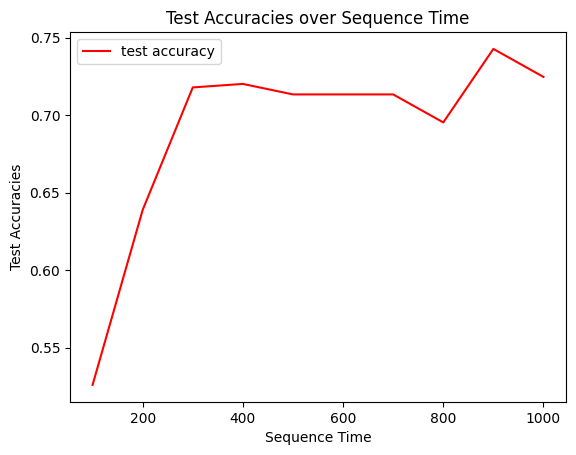

In [ ]:
make_figure(clips, test_accuracies, name = "EXP4")

In [ ]:
print("Best Test Accuracy: ", test_accuracies[8])

Best Test Accuracy:  0.7426636568848759
